In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 데이터 기본 전처리

In [3]:
# 파일 읽기
olym_df = pd.read_csv("올림픽대로_통행속도_기상.csv", encoding='cp949')
gaepo_df = pd.read_csv("개포로_통행속도_기상.csv", encoding='cp949')
nonhyun_df = pd.read_csv("논현로_통행속도_기상.csv", encoding='cp949')
dogog_df = pd.read_csv("도곡로_통행속도_기상.csv", encoding='cp949')

# 결측치 확인
print('올림픽대로 결측치 수 : ',olym_df['속도'].isna().sum())
print('개포로 결측치 수 : ',gaepo_df['속도'].isna().sum())
print('논현로 결측치 수 : ',nonhyun_df['속도'].isna().sum())
print('도곡로 결측치 수 : ',dogog_df['속도'].isna().sum())

/var/folders/0t/0jprd7f95qsb1p_xmw35n4l80000gn/T/ipykernel_13905/3343547820.py:3: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  gaepo_df = pd.read_csv("개포로_통행속도_기상.csv", encoding='cp949')


올림픽대로 결측치 수 :  1279
개포로 결측치 수 :  825
논현로 결측치 수 :  1047
도곡로 결측치 수 :  660


In [5]:
df = olym_df + gaepo_df + nonhyun_df + dogog_df
df['속도'].info()

<class 'pandas.core.series.Series'>
Index: 666216 entries, 0 to 666215
Series name: 속도
Non-Null Count   Dtype  
--------------   -----  
276675 non-null  float64
dtypes: float64(1)
memory usage: 10.2 MB


In [97]:
def fill_missing_values(df):
    # 일시 컬럼을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 시간 추출
    df['hour'] = df['일시'].dt.hour
    
    # 각 결측치에 대해
    null_indices = df[df['속도'].isnull()].index
    
    for idx in null_indices:
        current_row = df.loc[idx]
        
        # 현재 결측치의 조건과 동일한 데이터 필터링
        same_conditions = (
            (df['링크아이디'] == current_row['링크아이디']) & 
            (df['hour'] == current_row['hour']) & 
            (df['isHoliday'] == current_row['isHoliday']) &
            (df['속도'].notnull())  # 결측치가 아닌 데이터만
        )
        
        # 조건에 맞는 평균 속도 계산
        mean_speed = df[same_conditions]['속도'].mean()
        
        # 만약 조건에 맞는 데이터가 없다면 (mean_speed가 NaN이라면)
        # 휴일 조건을 제외하고 다시 계산
        if pd.isna(mean_speed):
            same_conditions = (
                (df['링크아이디'] == current_row['링크아이디']) & 
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 여전히 평균을 구할 수 없다면 전체 링크아이디의 해당 시간대 평균 사용
        if pd.isna(mean_speed):
            same_conditions = (
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 결측치 채우기
        df.loc[idx, '속도'] = mean_speed
        
    return df

# 사용 예시:
olym_df = fill_missing_values(olym_df.copy())
gaepo_df = fill_missing_values(gaepo_df.copy())
nonhyun_df = fill_missing_values(nonhyun_df.copy())
dogog_df = fill_missing_values(dogog_df.copy())

print('올림픽대로 결측치 수 : ',olym_df['속도'].isna().sum())
print('개포로 결측치 수 : ',gaepo_df['속도'].isna().sum())
print('논현로 결측치 수 : ',nonhyun_df['속도'].isna().sum())
print('도곡로 결측치 수 : ',dogog_df['속도'].isna().sum())

올림픽대로 결측치 수 :  0
개포로 결측치 수 :  0
논현로 결측치 수 :  0
도곡로 결측치 수 :  0


## 데이터 분석

### 이상치 제거 후 모델

In [35]:
olym_df.drop(columns = ['일자', '요일', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)
gaepo_df.drop(columns = ['일자', '요일', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)
nonhyun_df.drop(columns = ['일자', '요일', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)
dogog_df.drop(columns = ['일자', '요일', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)

In [36]:
# 한글 폰트 설정
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'AppleGothic'

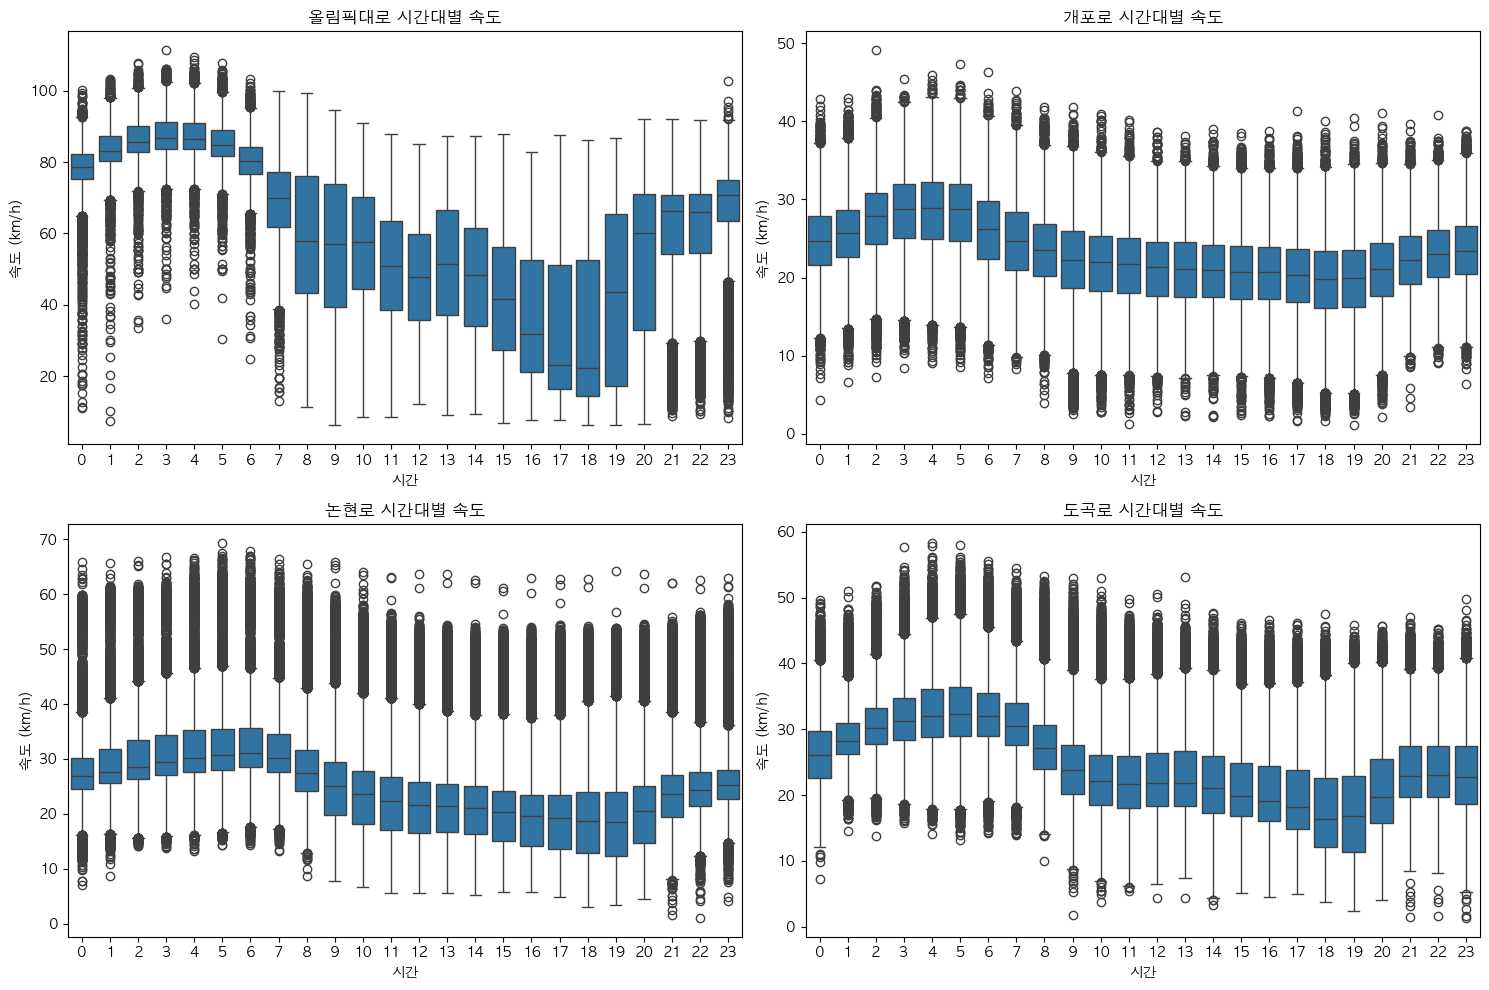


[올림픽대로 시간대별 속도 통계값]
        count       mean        std    min    25%        50%    75%     max
hour                                                                       
0     11652.0  78.343735   7.103477  11.00  75.33  78.500000  82.25  100.25
1     11652.0  83.759581   6.187102   7.50  80.17  83.108736  87.33  103.33
2     11652.0  86.334453   5.935146  33.58  82.75  85.500000  90.00  107.58
3     11652.0  87.442477   5.923412  35.92  83.75  86.670000  91.25  111.33
4     11652.0  87.289128   5.843871  40.33  83.58  86.580000  91.00  109.33
5     11652.0  85.249161   5.751584  30.33  81.67  84.670000  88.83  107.75
6     11652.0  80.370393   6.335624  24.92  76.75  80.420000  84.17  103.33
7     11652.0  69.161296  10.914601  13.17  61.83  70.000000  77.25   99.83
8     11652.0  58.393406  19.056070  11.50  43.33  58.000000  76.17   99.25
9     11652.0  56.272287  19.002985   6.25  39.50  57.170000  73.92   94.50
10    11652.0  56.158333  16.384653   8.58  44.50  57.670000  70.17

In [62]:
# 각 도로별 이상치 탐색
# 이상치 제거 전 박스플롯 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 올림픽대로 시간대별 이상치
sns.boxplot(data=olym_df, x='hour', y='속도', ax=axes[0,0])
axes[0,0].set_title('올림픽대로 시간대별 속도', fontsize=12)
axes[0,0].set_xlabel('시간')
axes[0,0].set_ylabel('속도 (km/h)')

# 개포로 시간대별 이상치
sns.boxplot(data=gaepo_df, x='hour', y='속도', ax=axes[0,1])
axes[0,1].set_title('개포로 시간대별 속도', fontsize=12)
axes[0,1].set_xlabel('시간')
axes[0,1].set_ylabel('속도 (km/h)')

# 논현로 시간대별 이상치
sns.boxplot(data=nonhyun_df, x='hour', y='속도', ax=axes[1,0])
axes[1,0].set_title('논현로 시간대별 속도', fontsize=12)
axes[1,0].set_xlabel('시간')
axes[1,0].set_ylabel('속도 (km/h)')

# 도곡로 시간대별 이상치
sns.boxplot(data=dogog_df, x='hour', y='속도', ax=axes[1,1])
axes[1,1].set_title('도곡로 시간대별 속도', fontsize=12)
axes[1,1].set_xlabel('시간')
axes[1,1].set_ylabel('속도 (km/h)')

plt.tight_layout()
plt.show()

# 통계값 출력
print("\n[올림픽대로 시간대별 속도 통계값]")
print(olym_df.groupby('hour')['속도'].describe())
print("\n[개포로 시간대별 속도 통계값]")
print(gaepo_df.groupby('hour')['속도'].describe())
print("\n[논현로 시간대별 속도 통계값]")
print(nonhyun_df.groupby('hour')['속도'].describe())
print("\n[도곡로 시간대별 속도 통계값]")
print(dogog_df.groupby('hour')['속도'].describe())


### 이상치 리스트 확인해보기

In [93]:
# 각 도로의 시간대별 평균 속도 계산
olym_mean = olym_df.groupby('hour')['속도'].mean()
gaepo_mean = gaepo_df.groupby('hour')['속도'].mean()
nonhyun_mean = nonhyun_df.groupby('hour')['속도'].mean()
dogog_mean = dogog_df.groupby('hour')['속도'].mean()

print("\n[각 도로의 시간대별 평균 속도]")
print("\n올림픽대로 시간대별 평균 속도:")
print(olym_mean)
print("\n개포로 시간대별 평균 속도:")
print(gaepo_mean) 
print("\n논현로 시간대별 평균 속도:")
print(nonhyun_mean)
print("\n도곡로 시간대별 평균 속도:")
print(dogog_mean)

# 올림픽대로와의 차이 계산
gaepo_diff = olym_mean - gaepo_mean
nonhyun_diff = olym_mean - nonhyun_mean
dogog_diff = olym_mean - dogog_mean

# 데이터프레임 생성
diff_df = pd.DataFrame({
    '개포로 차이': gaepo_diff,
    '논현로 차이': nonhyun_diff,
    '도곡로 차이': dogog_diff
})

# 테이블 출력
print("\n[올림픽대로 대비 각 도로 평균 속도 차이]")
print(diff_df.round(2))

# 전체 평균 차이 계산
mean_diff = pd.DataFrame({
    '도로명': ['개포로', '논현로', '도곡로'],
    '평균 차이': [
        sum(gaepo_diff)/24,
        sum(nonhyun_diff)/24,
        sum(dogog_diff)/24
    ]
})

print("\n[전체 평균 차이]")
print(mean_diff.round(2))



[각 도로의 시간대별 평균 속도]

올림픽대로 시간대별 평균 속도:
hour
0     78.343735
1     83.759581
2     86.334453
3     87.442477
4     87.289128
5     85.249161
6     80.370393
7     69.161296
8     58.393406
9     56.272287
10    56.158333
11    50.896877
12    48.209053
13    50.822149
14    48.042343
15    43.198193
16    38.278932
17    34.141890
18    33.913503
19    42.357837
20    52.263569
21    60.584974
22    61.430781
23    67.081541
Name: 속도, dtype: float64

개포로 시간대별 평균 속도:
hour
0     24.721221
1     25.645813
2     27.519913
3     28.352355
4     28.482556
5     28.194929
6     26.014216
7     24.647434
8     23.372580
9     21.939557
10    21.617269
11    21.352076
12    21.034795
13    21.076140
14    20.903580
15    20.671141
16    20.526885
17    20.084063
18    19.398903
19    19.595962
20    21.017694
21    22.213977
22    23.046231
23    23.498030
Name: 속도, dtype: float64

논현로 시간대별 평균 속도:
hour
0     28.708420
1     29.966269
2     30.907860
3     31.709392
4     32.385115
5     32.73755

올림픽대로 이상치 제거 전: 279648 후: 275744
개포로 이상치 제거 전: 525960 후: 522338
논현로 이상치 제거 전: 666216 후: 610622
도곡로 이상치 제거 전: 420768 후: 397549


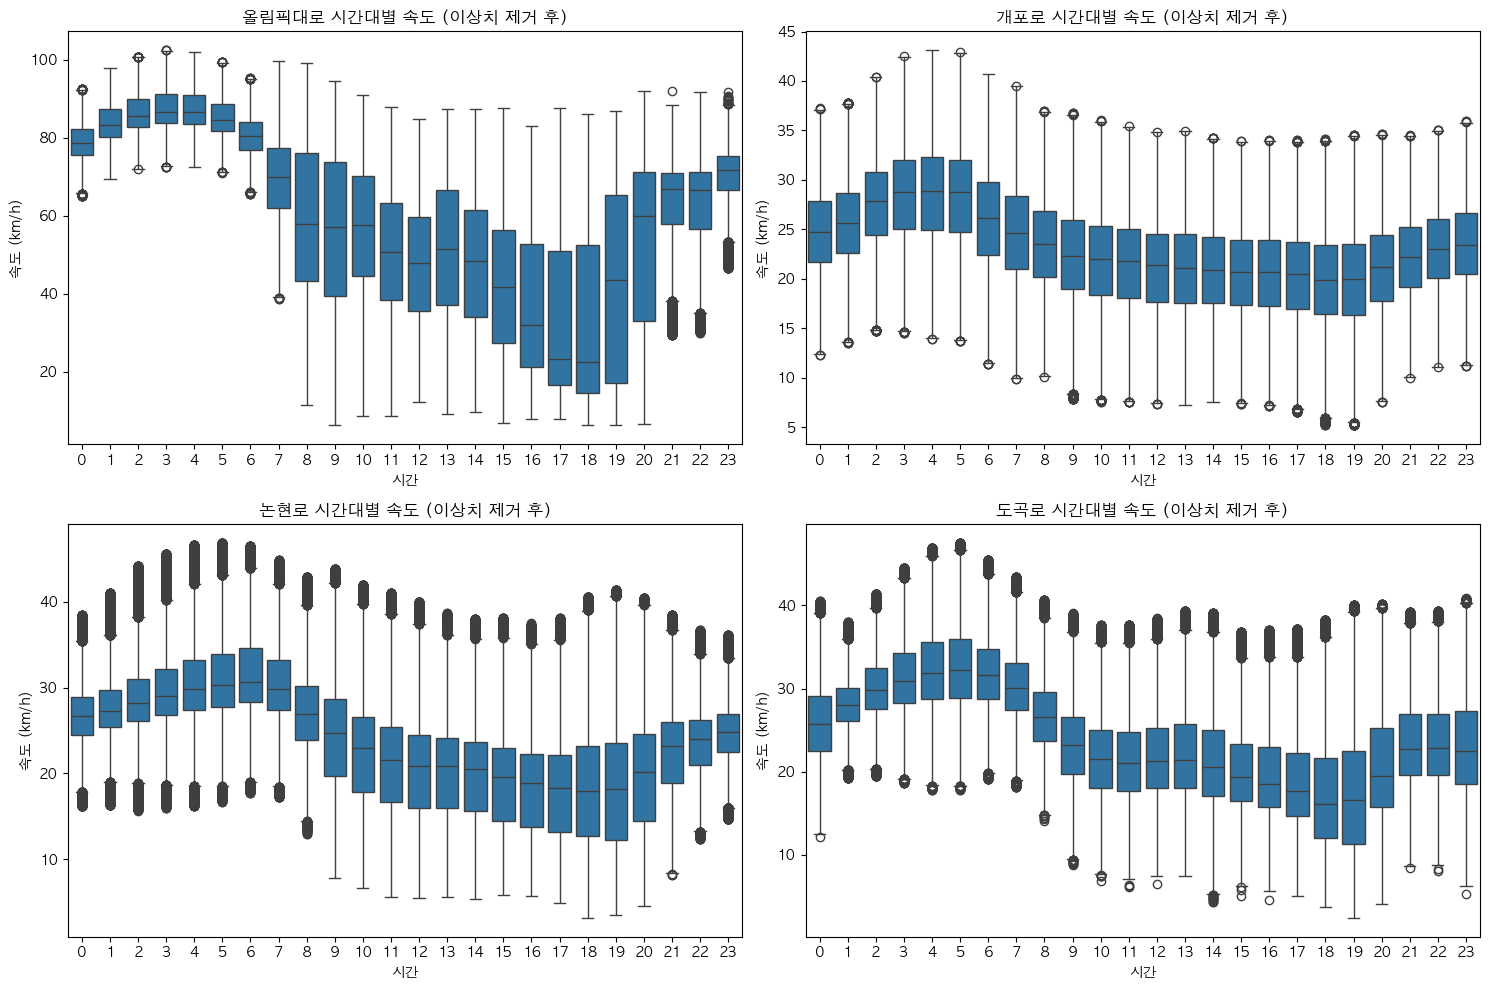


[올림픽대로 시간대별 속도 통계값 (이상치 제거 후)]
        count       mean        std    min    25%    50%    75%     max
hour                                                                   
0     11222.0  79.032661   5.256206  65.00  75.67  78.67  82.33   92.58
1     11475.0  83.998361   5.343272  69.50  80.25  83.17  87.42   98.00
2     11500.0  86.481843   5.357455  71.92  82.75  85.58  89.92  100.83
3     11505.0  87.576734   5.443270  72.50  83.83  86.75  91.25  102.50
4     11491.0  87.384050   5.370425  72.50  83.58  86.58  91.00  102.08
5     11471.0  85.361972   5.235745  71.00  81.75  84.67  88.75   99.50
6     11422.0  80.555432   5.649746  65.67  76.92  80.50  84.17   95.25
7     11567.0  69.435558  10.458777  38.75  62.00  70.08  77.33   99.83
8     11652.0  58.393406  19.056070  11.50  43.33  58.00  76.17   99.25
9     11652.0  56.272287  19.002985   6.25  39.50  57.17  73.92   94.50
10    11652.0  56.158333  16.384653   8.58  44.50  57.67  70.17   91.00
11    11652.0  50.896877  15.821

In [54]:
# 각 도로별 이상치 제거 기준 설정 및 제거
def remove_outliers(df):
    # 시간대별로 그룹화하여 이상치 제거
    df_clean = pd.DataFrame()
    
    for hour in df['hour'].unique():
        # 해당 시간대 데이터 추출
        hour_data = df[df['hour'] == hour].copy()
        
        # 해당 시간대의 IQR 계산
        Q1 = hour_data['속도'].quantile(0.25)
        Q3 = hour_data['속도'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 제거
        hour_data_clean = hour_data[(hour_data['속도'] >= lower_bound) & 
                                  (hour_data['속도'] <= upper_bound)]
        
        # 정제된 데이터 추가
        df_clean = pd.concat([df_clean, hour_data_clean])
    
    return df_clean

# 각 도로별 이상치 제거
olym_df_clean = remove_outliers(olym_df.copy())
gaepo_df_clean = remove_outliers(gaepo_df.copy())
nonhyun_df_clean = remove_outliers(nonhyun_df.copy())
dogog_df_clean = remove_outliers(dogog_df.copy())

# 이상치 제거 전후 데이터 수 비교
print('올림픽대로 이상치 제거 전:', len(olym_df), '후:', len(olym_df_clean))
print('개포로 이상치 제거 전:', len(gaepo_df), '후:', len(gaepo_df_clean))
print('논현로 이상치 제거 전:', len(nonhyun_df), '후:', len(nonhyun_df_clean))
print('도곡로 이상치 제거 전:', len(dogog_df), '후:', len(dogog_df_clean))

# 이상치 제거 후 박스플롯 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 올림픽대로 시간대별 이상치
sns.boxplot(data=olym_df_clean, x='hour', y='속도', ax=axes[0,0])
axes[0,0].set_title('올림픽대로 시간대별 속도 (이상치 제거 후)', fontsize=12)
axes[0,0].set_xlabel('시간')
axes[0,0].set_ylabel('속도 (km/h)')

# 개포로 시간대별 이상치
sns.boxplot(data=gaepo_df_clean, x='hour', y='속도', ax=axes[0,1])
axes[0,1].set_title('개포로 시간대별 속도 (이상치 제거 후)', fontsize=12)
axes[0,1].set_xlabel('시간')
axes[0,1].set_ylabel('속도 (km/h)')

# 논현로 시간대별 이상치
sns.boxplot(data=nonhyun_df_clean, x='hour', y='속도', ax=axes[1,0])
axes[1,0].set_title('논현로 시간대별 속도 (이상치 제거 후)', fontsize=12)
axes[1,0].set_xlabel('시간')
axes[1,0].set_ylabel('속도 (km/h)')

# 도곡로 시간대별 이상치
sns.boxplot(data=dogog_df_clean, x='hour', y='속도', ax=axes[1,1])
axes[1,1].set_title('도곡로 시간대별 속도 (이상치 제거 후)', fontsize=12)
axes[1,1].set_xlabel('시간')
axes[1,1].set_ylabel('속도 (km/h)')

plt.tight_layout()
plt.show()

# 이상치 제거 후 통계값 출력
print("\n[올림픽대로 시간대별 속도 통계값 (이상치 제거 후)]")
print(olym_df_clean.groupby('hour')['속도'].describe())
print("\n[개포로 시간대별 속도 통계값 (이상치 제거 후)]")
print(gaepo_df_clean.groupby('hour')['속도'].describe())
print("\n[논현로 시간대별 속도 통계값 (이상치 제거 후)]")
print(nonhyun_df_clean.groupby('hour')['속도'].describe())
print("\n[도곡로 시간대별 속도 통계값 (이상치 제거 후)]")
print(dogog_df_clean.groupby('hour')['속도'].describe())


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [78]:
def train_lstm_model(df, name, target_col, time_steps=24, train_ratio=0.8, epochs=50, batch_size=32):
    """
    LSTM 모델을 학습하고 예측하는 함수
    
    Parameters:
    -----------
    df : DataFrame
        입력 데이터프레임
    target_col : str 
        예측하고자 하는 타겟 컬럼명
    time_steps : int
        시계열 데이터의 시간 스텝 (기본값: 24)
    train_ratio : float
        학습 데이터 비율 (기본값: 0.8)
    epochs : int
        학습 에포크 수 (기본값: 50)
    batch_size : int
        배치 크기 (기본값: 32)
    """
    
    unique_links = df['링크아이디'].unique()
    results = {}
    
    for link_id in unique_links:
        print(f"\n링크아이디 {link_id}에 대한 분석")
        
        # 해당 링크의 데이터만 추출
        link_df = df[df['링크아이디'] == link_id]
        
        # 데이터 전처리
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(link_df[target_col].values.reshape(-1,1))

        # 시계열 데이터셋 생성
        def create_dataset(data, time_steps=1):
            X, y = [], []
            for i in range(len(data) - time_steps):
                X.append(data[i:(i + time_steps), 0])
                y.append(data[i + time_steps, 0])
            return np.array(X), np.array(y)

        # 시계열 데이터 생성
        X, y = create_dataset(scaled_data, time_steps)

        # 학습/테스트 데이터 분할
        train_size = int(len(X) * train_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # 데이터 reshape (LSTM 입력 형태로)
        X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 1))
        X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

        # LSTM 모델 구성
        model = Sequential([
            LSTM(128, activation='tanh', input_shape=(time_steps, 1), return_sequences=True),
            LSTM(64, activation='tanh'),  # return_sequences 제거
            Dense(16, activation='relu'),
            Dense(1)
        ])

        # 모델 컴파일
        model.compile(optimizer='adam', loss='mse')

        # 모델 학습
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=0)

        # 예측
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # 예측값 역변환
        train_predict = scaler.inverse_transform(train_predict)
        y_train_inv = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test_inv = scaler.inverse_transform([y_test])

        # 결과 시각화
        plt.figure(figsize=(15,6))
        plt.plot(y_test_inv.T, label='실제값')
        plt.plot(test_predict, label='예측값')
        plt.title(f'{name} 링크 {link_id} {target_col} 예측 결과')
        plt.xlabel('시간')
        plt.ylabel(target_col)
        plt.legend()
        plt.show()

        # 모델 평가 결과 저장
        results[link_id] = {
            'model': model,
            'scaler': scaler,
            'metrics': {
                'Train RMSE': np.sqrt(mean_squared_error(y_train_inv.T, train_predict)),
                'Test RMSE': np.sqrt(mean_squared_error(y_test_inv.T, test_predict)),
                'Train MAE': mean_absolute_error(y_train_inv.T, train_predict),
                'Test MAE': mean_absolute_error(y_test_inv.T, test_predict),
                'Train R2': r2_score(y_train_inv.T, train_predict),
                'Test R2': r2_score(y_test_inv.T, test_predict),
                'Train Adjusted R2': 1 - (1-r2_score(y_train_inv.T, train_predict))*(len(y_train_inv.T)-1)/(len(y_train_inv.T)-1-1),
                'Test Adjusted R2': 1 - (1-r2_score(y_test_inv.T, test_predict))*(len(y_test_inv.T)-1)/(len(y_test_inv.T)-1-1)
            }
        }
        
        # 평가 결과 출력
        print(f'{name}의 링크 {link_id} 평가 결과:')
        for metric, value in results[link_id]['metrics'].items():
            print(f'{metric}: {value}')
        print('-' * 50)
    
    return results

# 사용 예시:
# results = train_lstm_model(dogog_df, target_col='속도')

### 모델 결과

### EDA

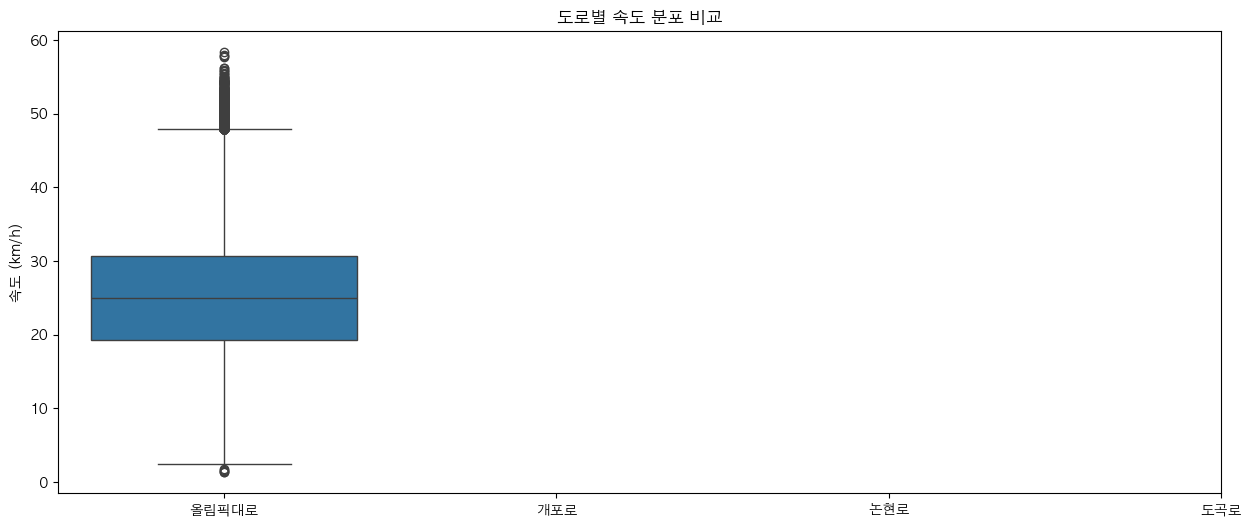

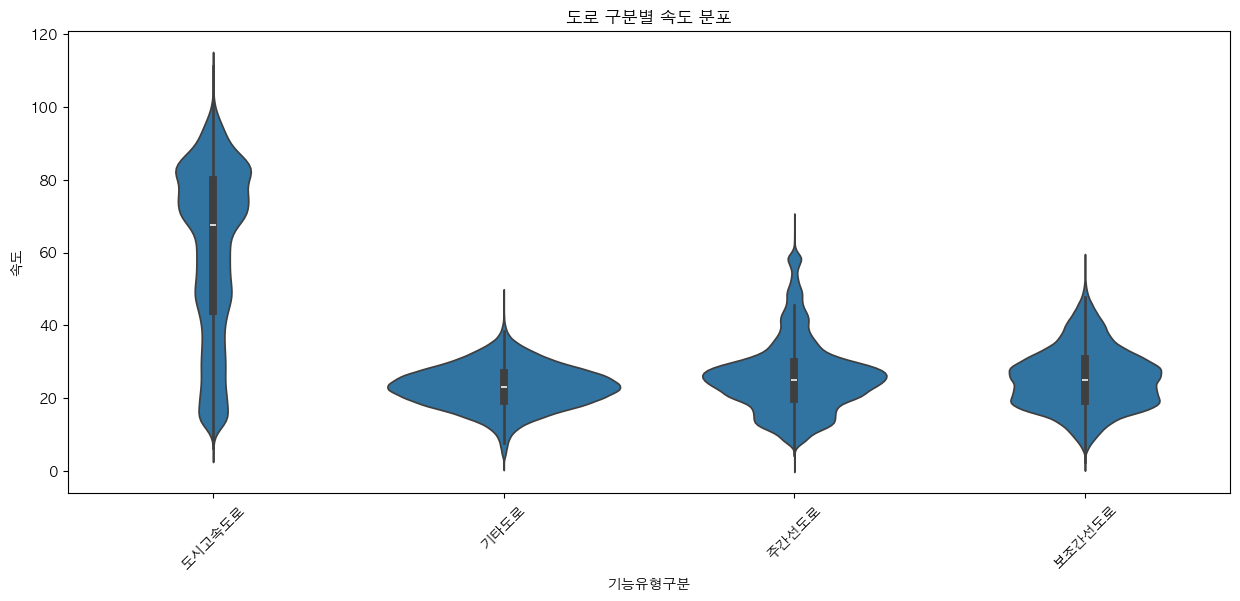

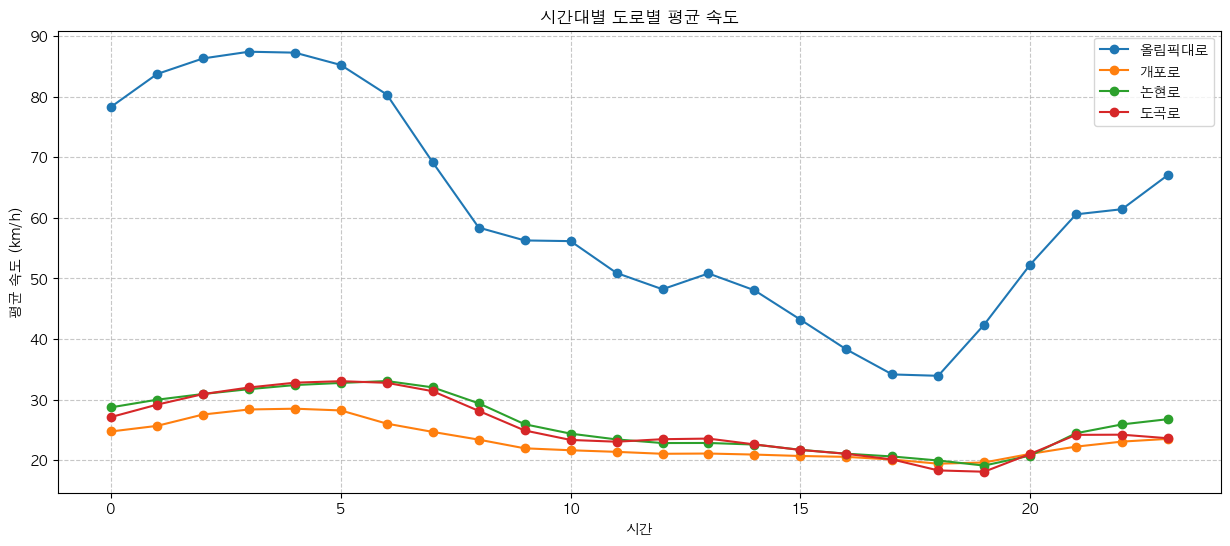

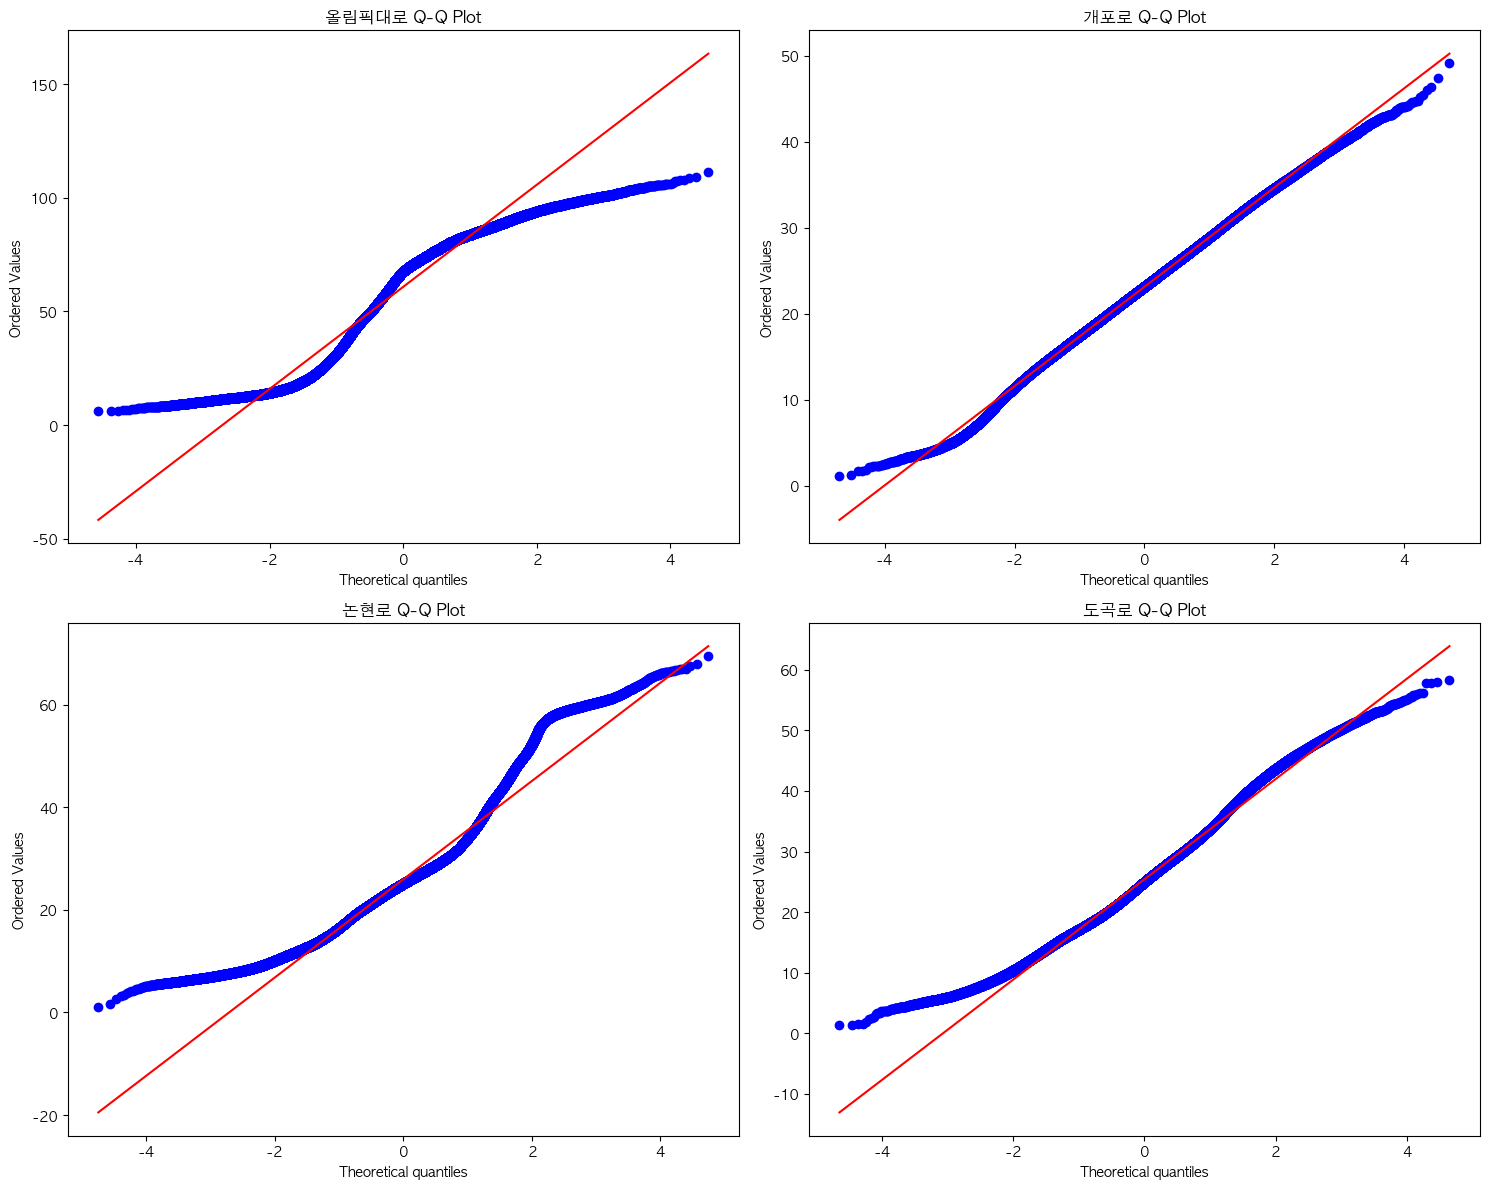

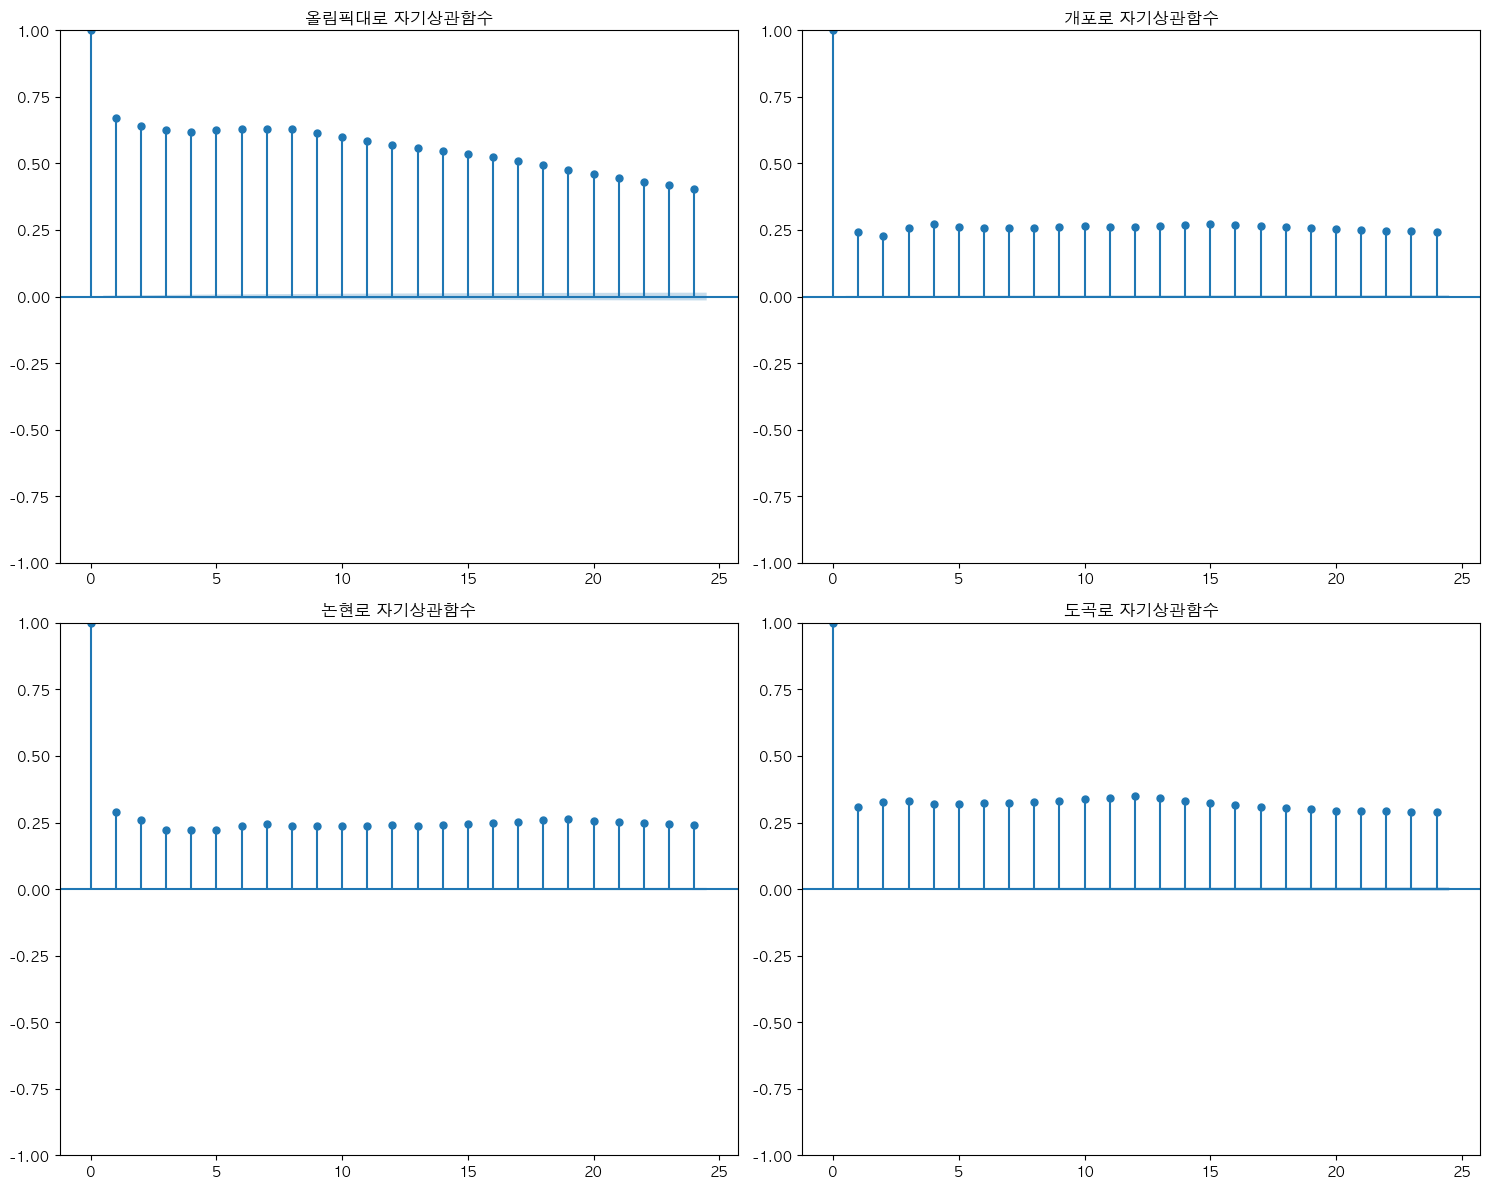

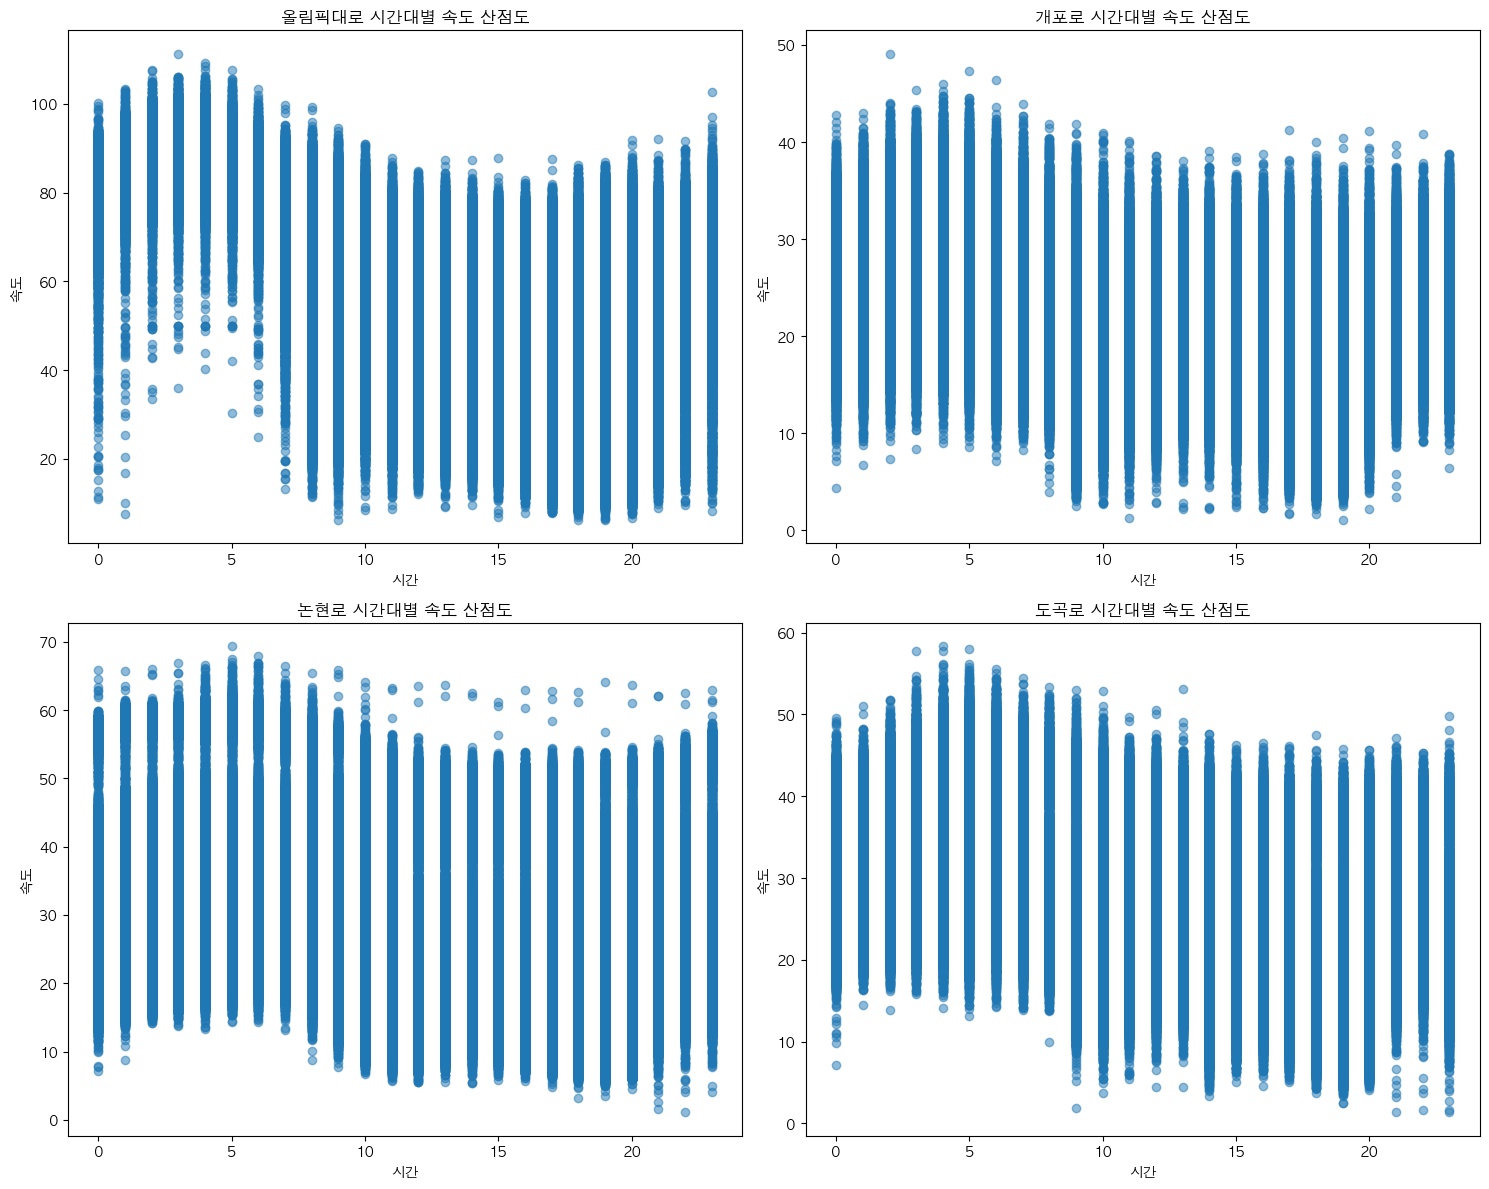

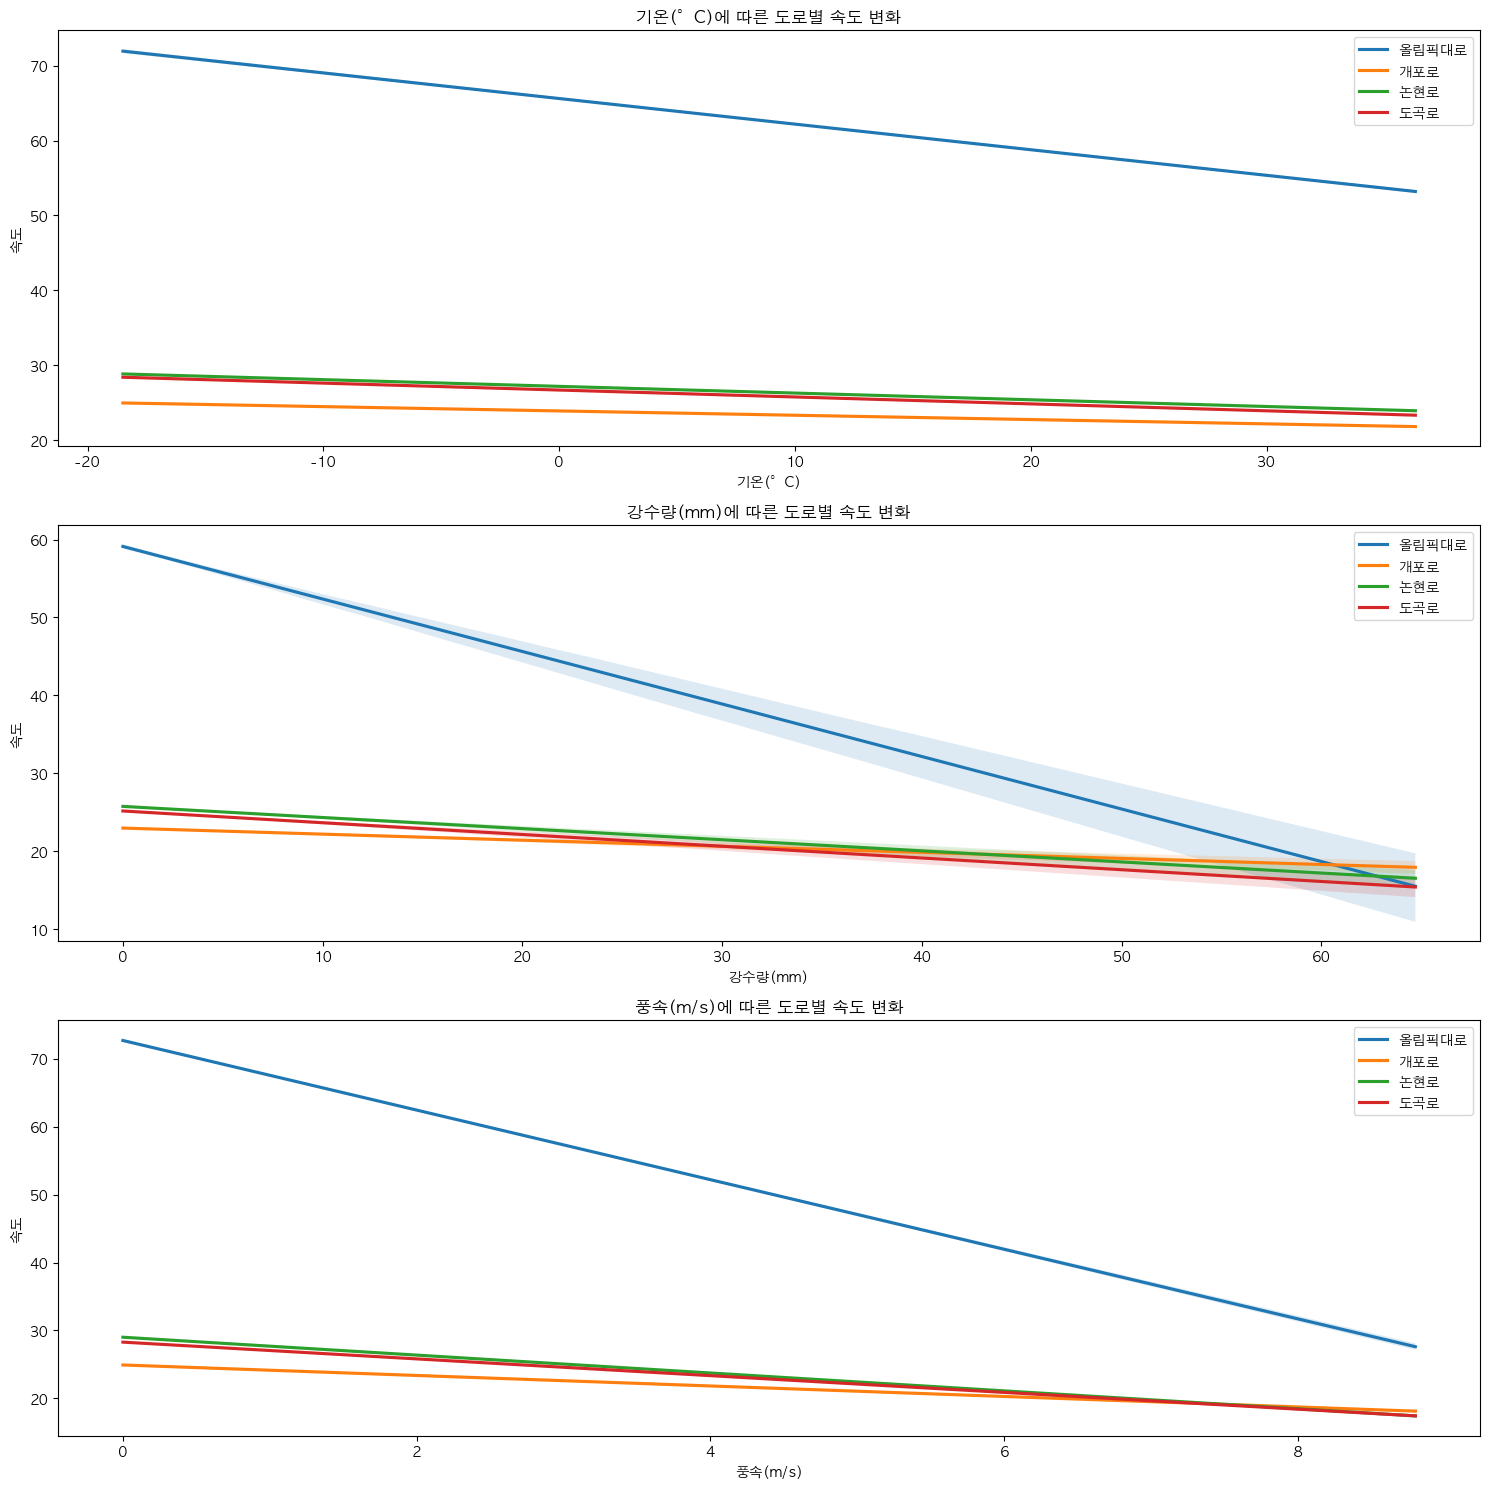


=== 도로별 정규성 검정 (Shapiro-Wilk) ===
올림픽대로: statistic=0.9357, p-value=0.0000
개포로: statistic=0.9994, p-value=0.0000
논현로: statistic=0.9480, p-value=0.0000
도곡로: statistic=0.9905, p-value=0.0000

=== 도로 간 평균 속도 차이 검정 (ANOVA) ===
F-statistic=747923.4786, p-value=0.0000


/opt/anaconda3/envs/sun_chnn/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 279648.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/sun_chnn/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 525960.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/sun_chnn/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 666216.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/sun_chnn/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 420768.
  res = hypotest_fun_out(*samples, **kwds)


In [98]:
# 도로별 기본 통계 분석 및 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. 도로별 속도 분포 비교
plt.figure(figsize=(15, 6))
sns.boxplot(data=[olym_df['속도'], gaepo_df['속도'], nonhyun_df['속도'], dogog_df['속도']])
plt.xticks(range(4), ['올림픽대로', '개포로', '논현로', '도곡로'])
plt.title('도로별 속도 분포 비교')
plt.ylabel('속도 (km/h)')
plt.show()

# 2. 도로 구분별 속도 분포
roads_df = pd.concat([
    olym_df.assign(도로='올림픽대로'),
    gaepo_df.assign(도로='개포로'),
    nonhyun_df.assign(도로='논현로'),
    dogog_df.assign(도로='도곡로')
])

plt.figure(figsize=(15, 6))
sns.violinplot(data=roads_df, x='기능유형구분', y='속도')
plt.title('도로 구분별 속도 분포')
plt.xticks(rotation=45)
plt.show()

# 3. 시간대별 도로별 평균 속도 비교
plt.figure(figsize=(15, 6))
for df, name in [(olym_df, '올림픽대로'), (gaepo_df, '개포로'), 
                 (nonhyun_df, '논현로'), (dogog_df, '도곡로')]:
    hourly_mean = df.groupby('hour')['속도'].mean()
    plt.plot(hourly_mean.index, hourly_mean.values, marker='o', label=name)

plt.title('시간대별 도로별 평균 속도')
plt.xlabel('시간')
plt.ylabel('평균 속도 (km/h)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 4. 정규성 검정 및 Q-Q plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
roads = [(olym_df, '올림픽대로'), (gaepo_df, '개포로'), 
         (nonhyun_df, '논현로'), (dogog_df, '도곡로')]

for (df, name), ax in zip(roads, axes.ravel()):
    stats.probplot(df['속도'], dist="norm", plot=ax)
    ax.set_title(f'{name} Q-Q Plot')

plt.tight_layout()
plt.show()

# 5. 자기상관 분석
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for (df, name), ax in zip(roads, axes.ravel()):
    plot_acf(df['속도'], ax=ax, lags=24)
    ax.set_title(f'{name} 자기상관함수')

plt.tight_layout()
plt.show()

# 6. 이분산성 검정을 위한 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for (df, name), ax in zip(roads, axes.ravel()):
    ax.scatter(df['hour'], df['속도'], alpha=0.5)
    ax.set_title(f'{name} 시간대별 속도 산점도')
    ax.set_xlabel('시간')
    ax.set_ylabel('속도')

plt.tight_layout()
plt.show()

# 7. 기상 조건에 따른 도로별 속도 변화
weather_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)']
fig, axes = plt.subplots(len(weather_cols), 1, figsize=(15, 15))

for idx, weather in enumerate(weather_cols):
    for df, name in roads:
        sns.regplot(data=df, x=weather, y='속도', 
                   scatter=False, label=name, ax=axes[idx])
    axes[idx].set_title(f'{weather}에 따른 도로별 속도 변화')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# 8. 통계적 검정 결과 출력
print("\n=== 도로별 정규성 검정 (Shapiro-Wilk) ===")
for df, name in roads:
    stat, p_value = stats.shapiro(df['속도'])
    print(f"{name}: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n=== 도로 간 평균 속도 차이 검정 (ANOVA) ===")
speeds = [df['속도'] for df, _ in roads]
f_stat, p_value = stats.f_oneway(*speeds)
print(f"F-statistic={f_stat:.4f}, p-value={p_value:.4f}")

In [100]:
olym_df.keys()

Index(['일자', '요일', '도로명', '링크아이디', '시점명', '종점명', '방향', '거리', '차선수', '기능유형구분',
       '도심/외곽구분', '권역구분', '시간', '속도', '일시', '지점', '지점명', '기온(°C)', '강수량(mm)',
       '풍속(m/s)', '풍향(16방위)', '적설(cm)', 'seq', 'dateKind', 'isHoliday',
       'dateName', 'hour'],
      dtype='object')

### 교통 시각화

In [102]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def analyze_traffic_data(df):
    """
    교통 데이터 분석을 위한 시각화 함수
    
    Parameters:
    df : DataFrame
        분석할 교통 데이터가 담긴 데이터프레임
    """
    # 1. 속도 분포 시각화
    plt.figure(figsize=(15, 5))

    # 히스토그램과 KDE
    plt.subplot(121)
    sns.histplot(data=df, x='속도', kde=True)
    plt.title('속도 분포 (히스토그램 + KDE)', fontsize=12)
    plt.xlabel('속도 (km/h)')
    plt.ylabel('빈도')

    # 박스플롯으로 이상치 확인
    plt.subplot(122)
    sns.boxplot(data=df, y='속도')
    plt.title('속도 분포 (박스플롯)', fontsize=12)
    plt.ylabel('속도 (km/h)')

    plt.tight_layout()
    plt.show()

    # 2. 상관관계 분석
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    correlation = df[numeric_cols].corr().round(3)

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('변수 간 상관관계', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 3. 시계열 정상성 검정 (ADF 테스트)
    def adf_test(series):
        result = adfuller(series)
        print('ADF 통계량:', result[0])
        print('p-value:', result[1]) 
        print('임계값:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

    # 시간순으로 정렬
    df['일시'] = pd.to_datetime(df['일시'])
    time_series = df.sort_values('일시').set_index('일시')['속도']

    print("\nADF 테스트 결과:")
    adf_test(time_series)

    # 4. ACF/PACF 플롯
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plot_acf(time_series, lags=24)
    plt.title('자기상관함수 (ACF)', fontsize=12)

    plt.subplot(122)
    plot_pacf(time_series, lags=24)
    plt.title('부분자기상관함수 (PACF)', fontsize=12)

    plt.tight_layout()
    plt.show()

    # 5. 시간대별 속도의 분포 (바이올린 플롯)
    plt.figure(figsize=(15, 6))
    sns.violinplot(data=df, x='시간', y='속도')
    plt.title('시간대별 속도 분포', fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel('시간')
    plt.ylabel('속도 (km/h)')
    plt.tight_layout()
    plt.show()

    # 6. 기상 조건에 따른 속도 분포
    weather_cols = ['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()

    for idx, col in enumerate(weather_cols):
        if col in df.columns:  # 컬럼이 존재할 경우에만 그리기
            sns.scatterplot(data=df, x=col, y='속도', alpha=0.5, ax=axes[idx])
            axes[idx].set_title(f'속도 vs {col}')

    plt.tight_layout()
    plt.show()

### 올림픽대로

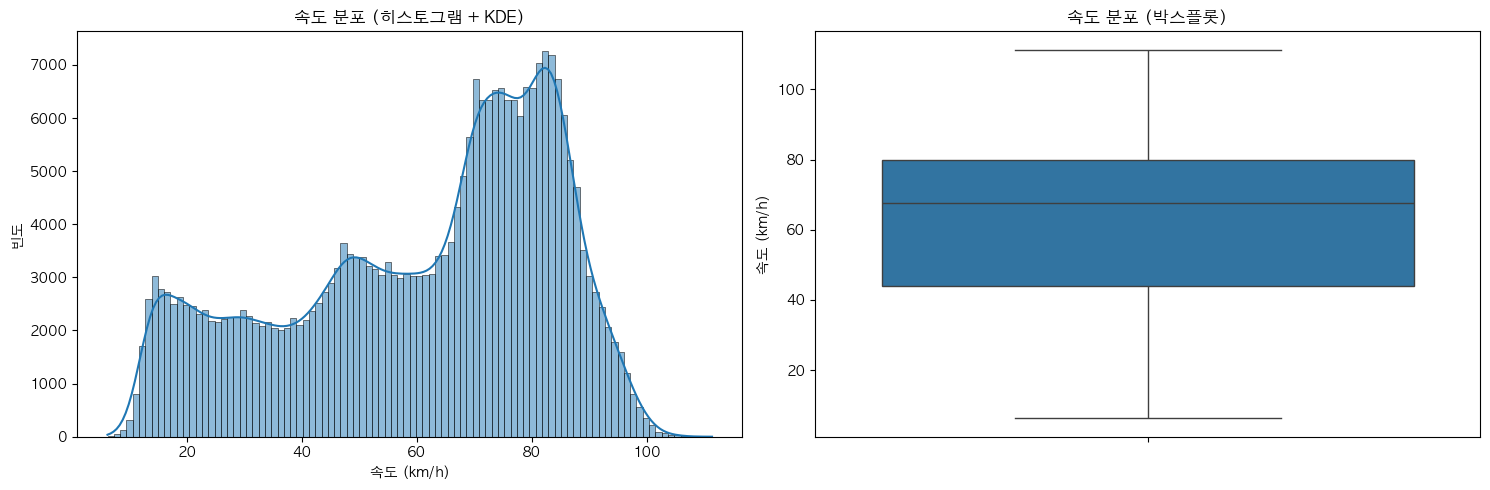

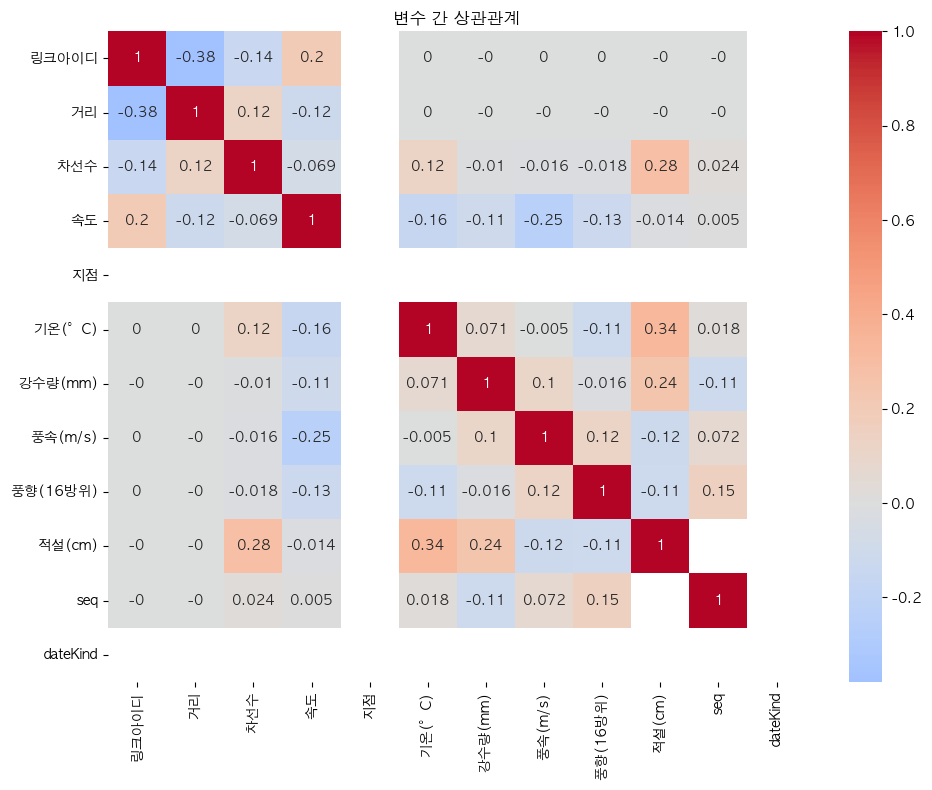


ADF 테스트 결과:
ADF 통계량: -91.33955688994422
p-value: 0.0
임계값:
	1%: -3.430
	5%: -2.862
	10%: -2.567


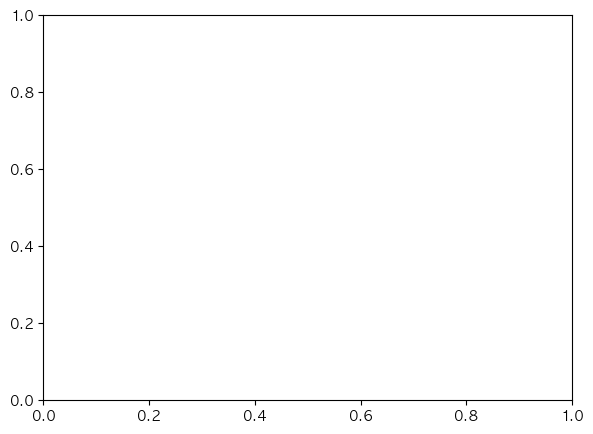

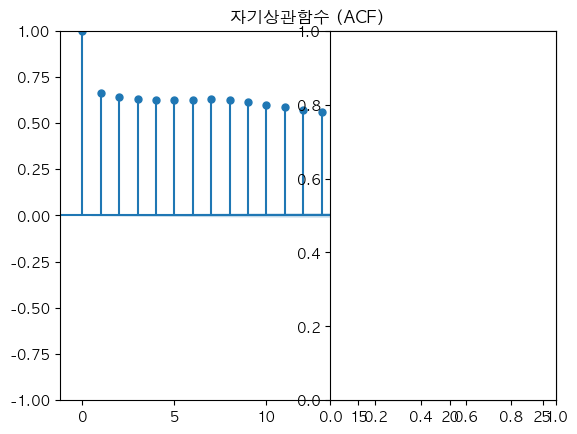

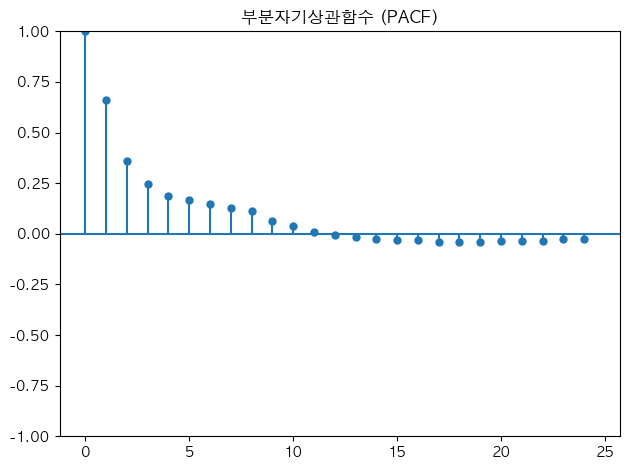

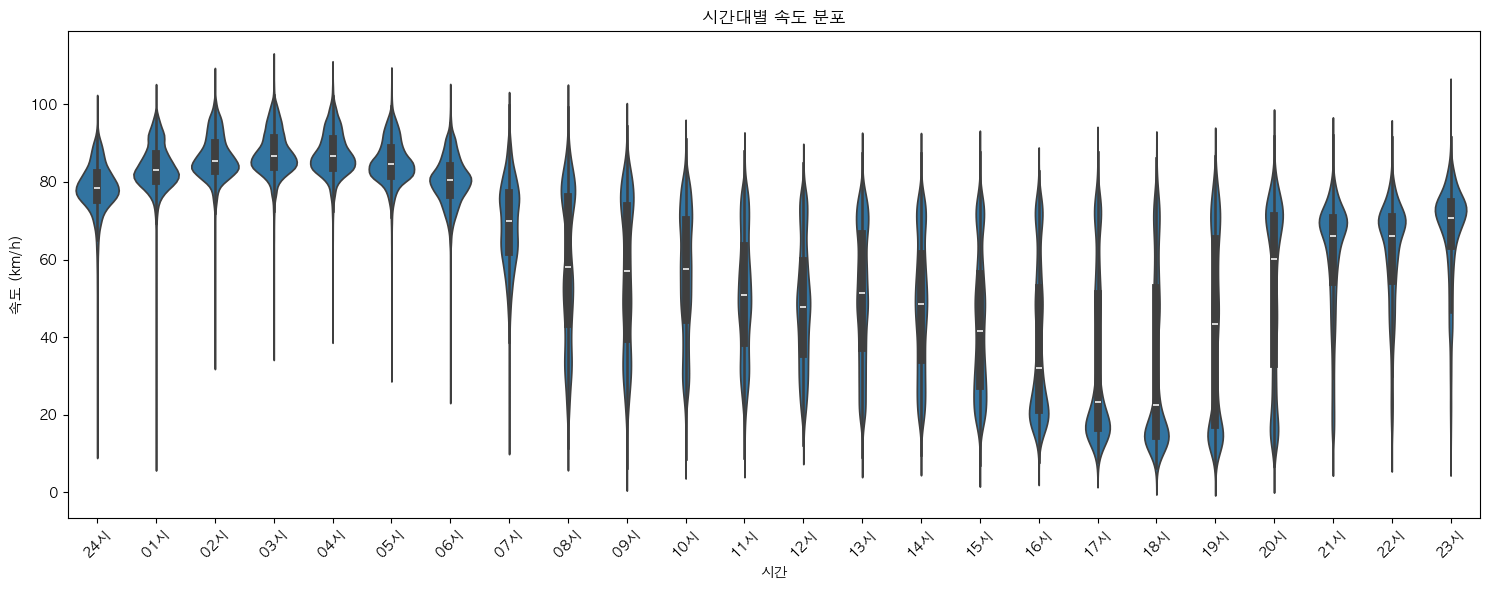

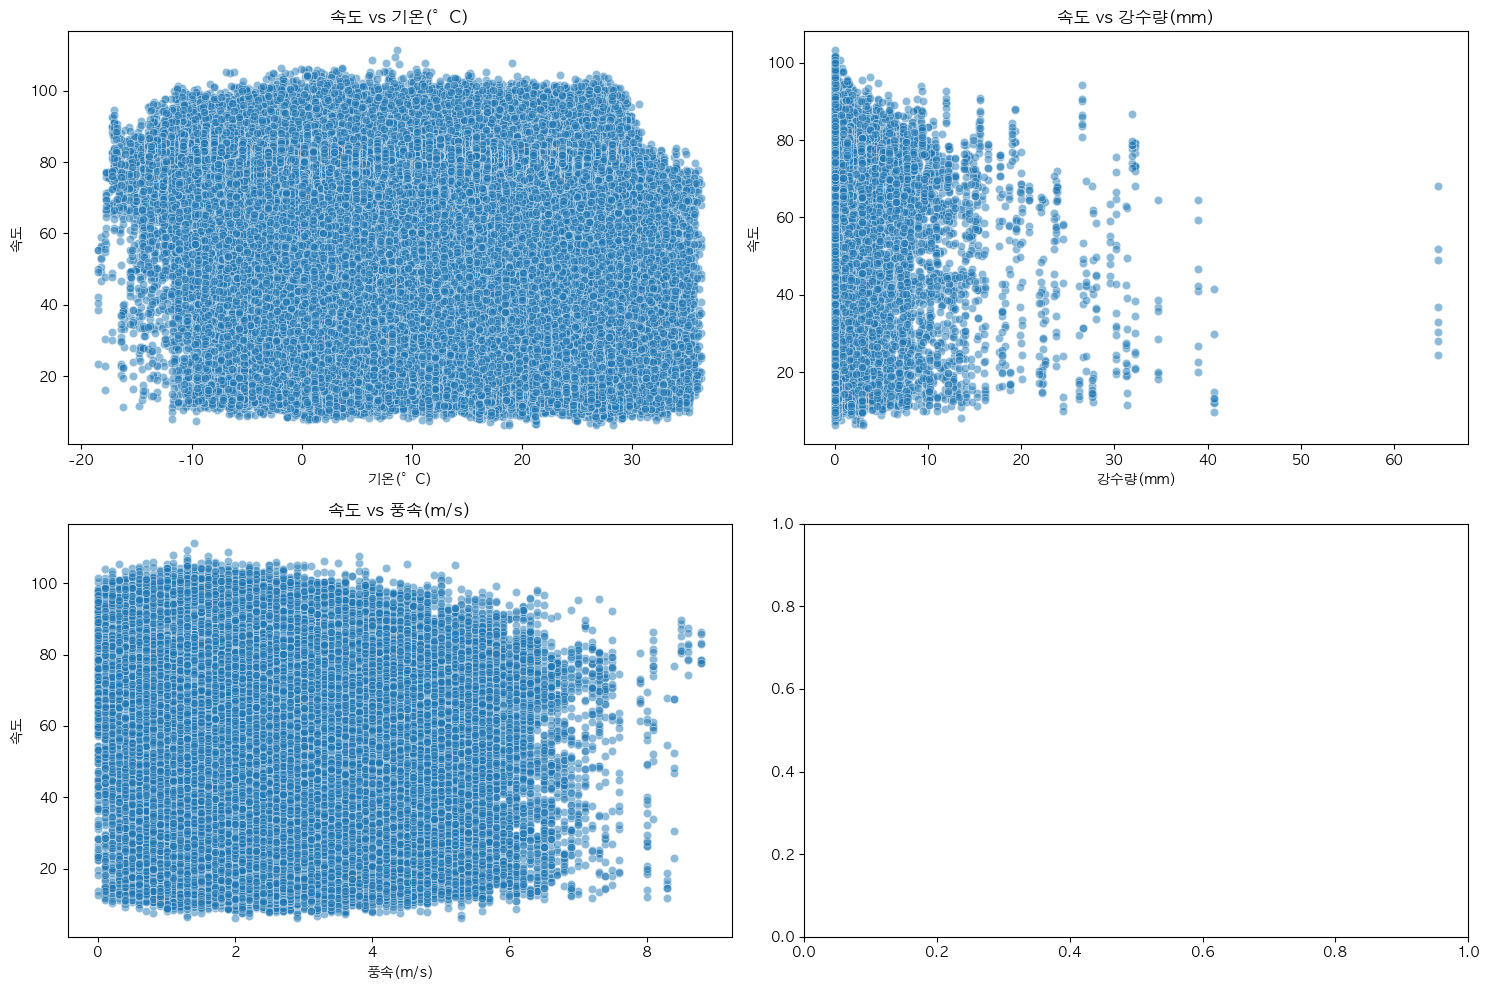

In [106]:
analyze_traffic_data(olym_df)

### 도곡로

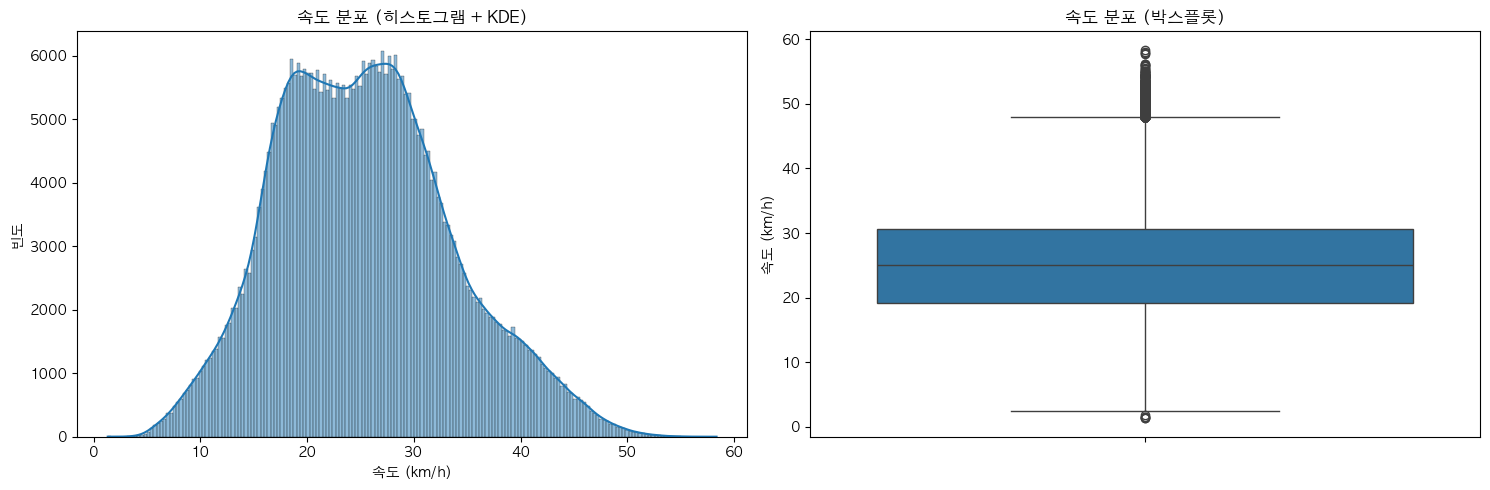

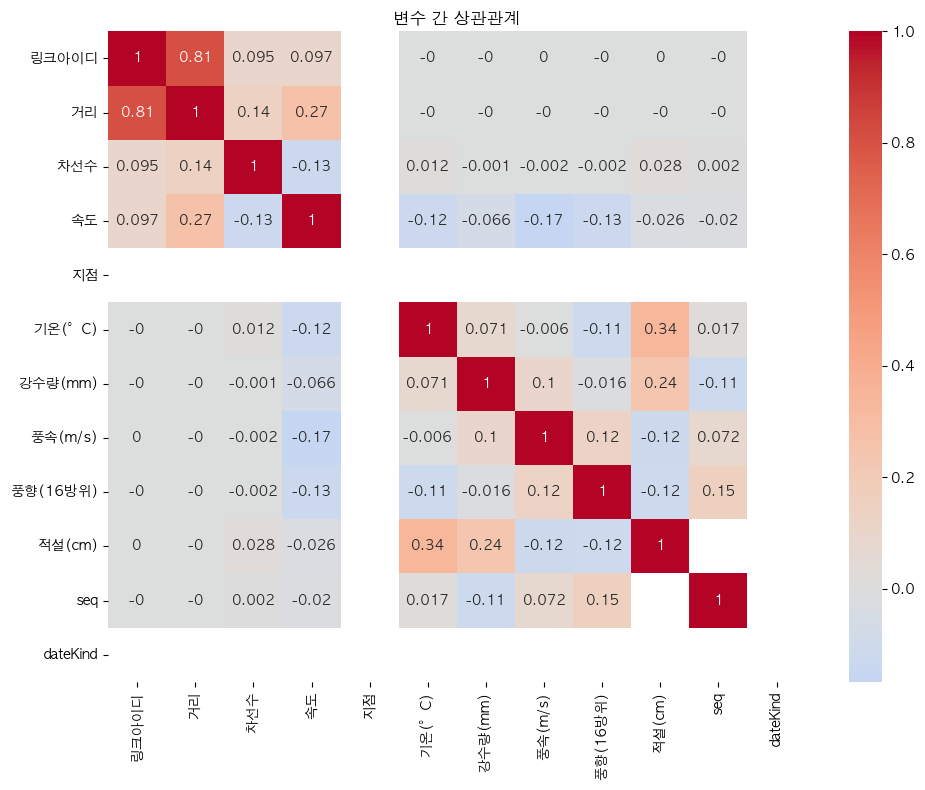


ADF 테스트 결과:
ADF 통계량: -76.09449267034714
p-value: 0.0
임계값:
	1%: -3.430
	5%: -2.862
	10%: -2.567


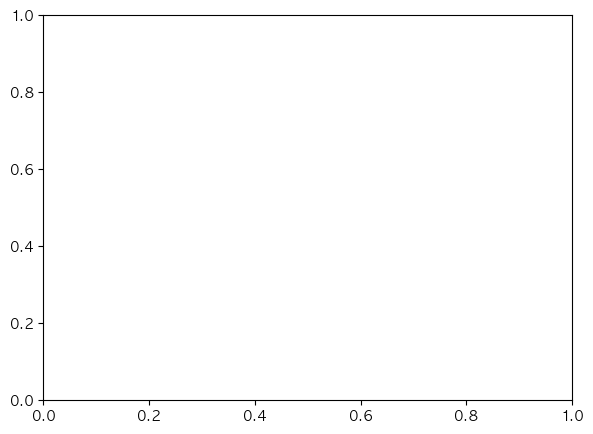

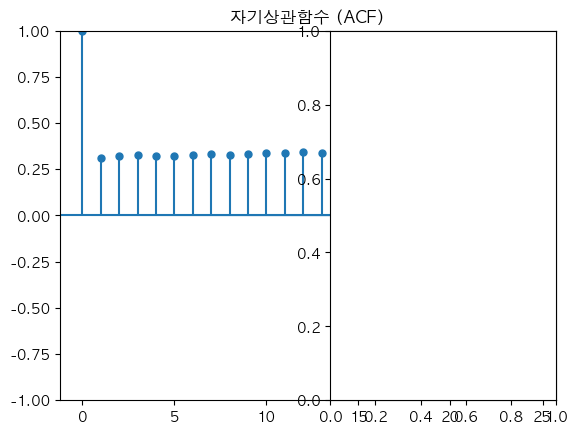

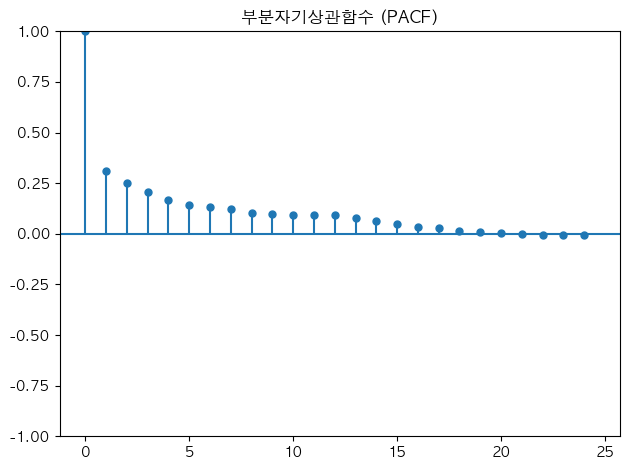

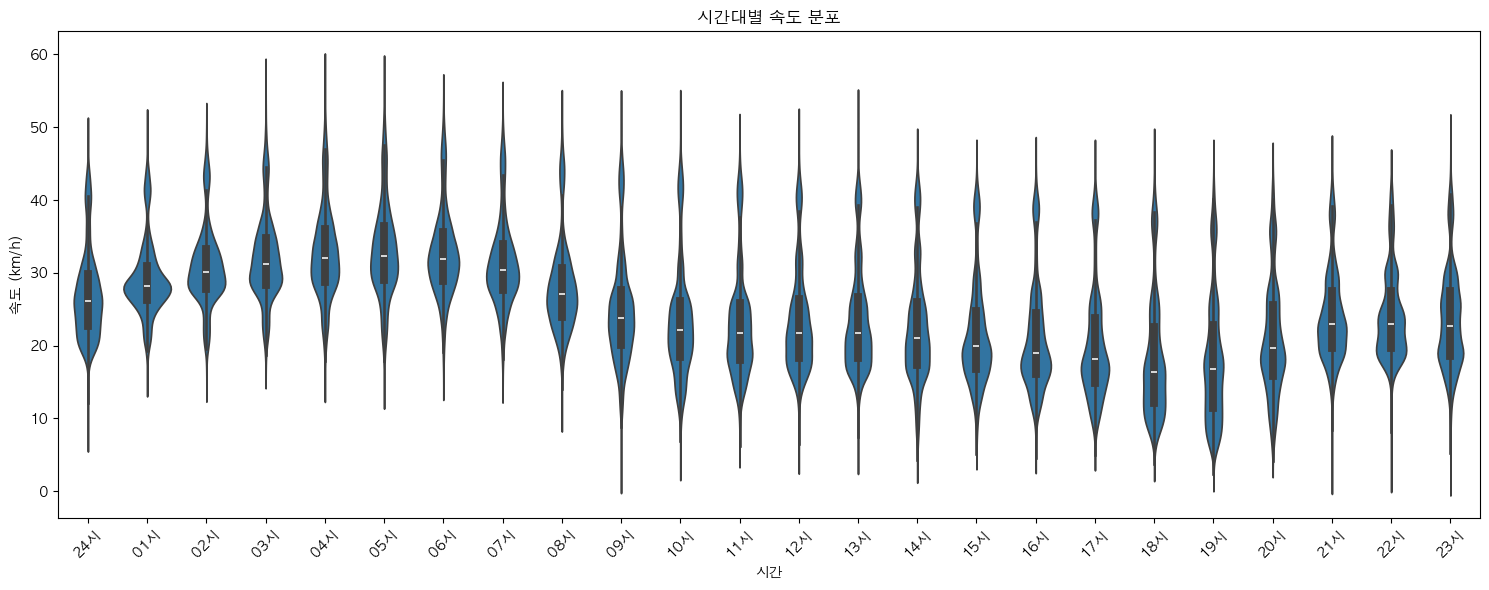

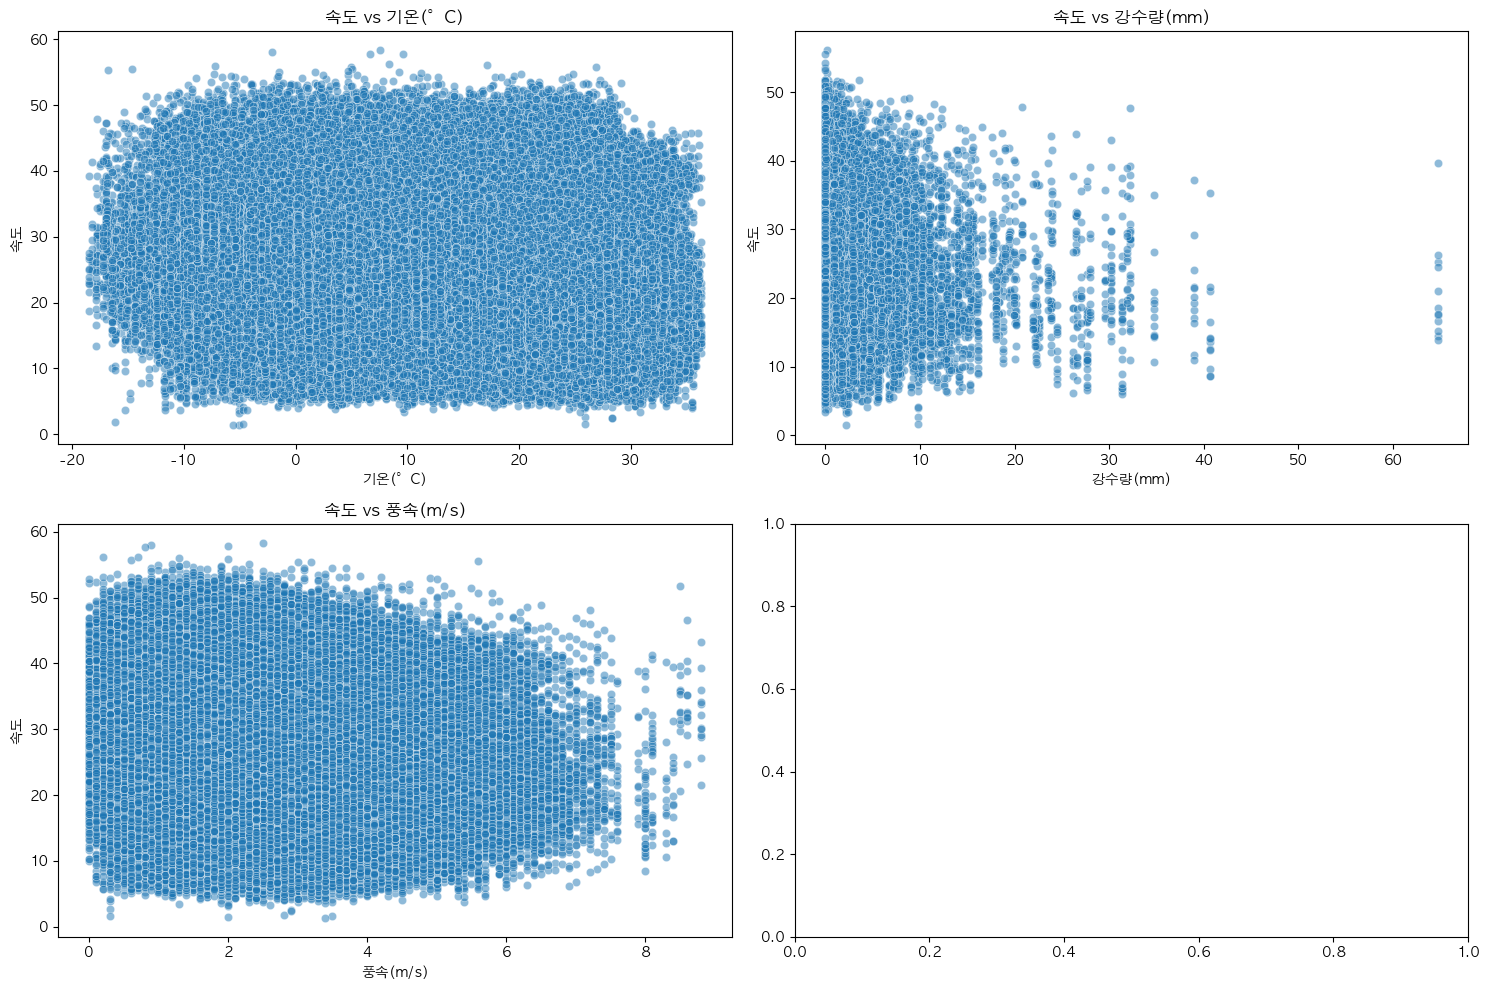

In [105]:
analyze_traffic_data(dogog_df)


### 개포로


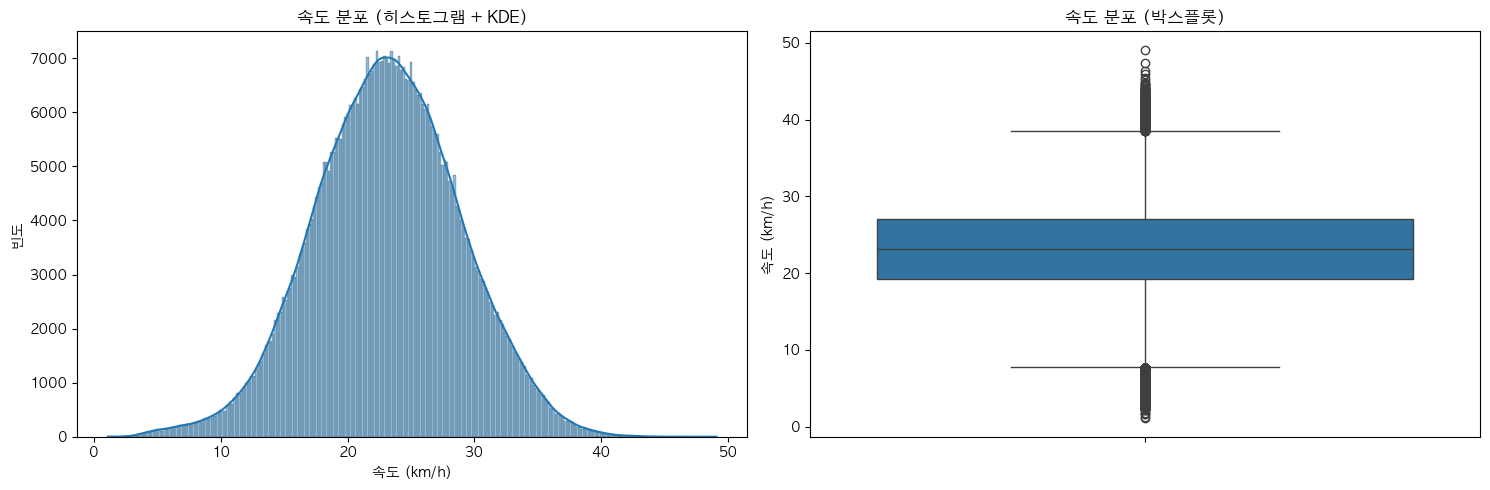

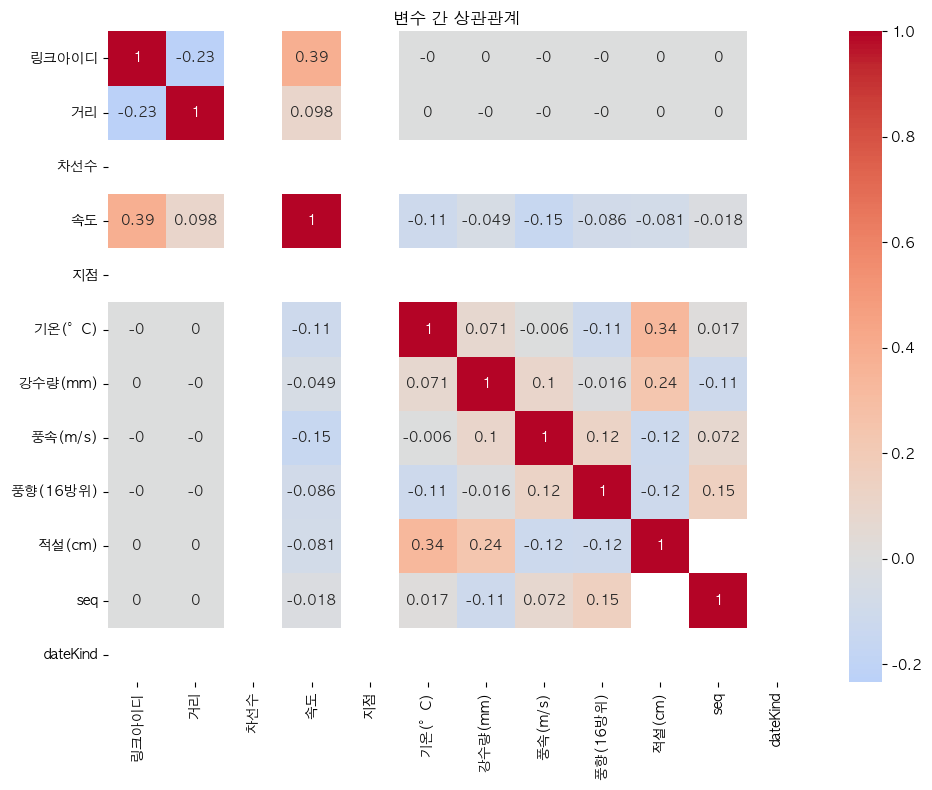


ADF 테스트 결과:
ADF 통계량: -75.91040213368272
p-value: 0.0
임계값:
	1%: -3.430
	5%: -2.862
	10%: -2.567


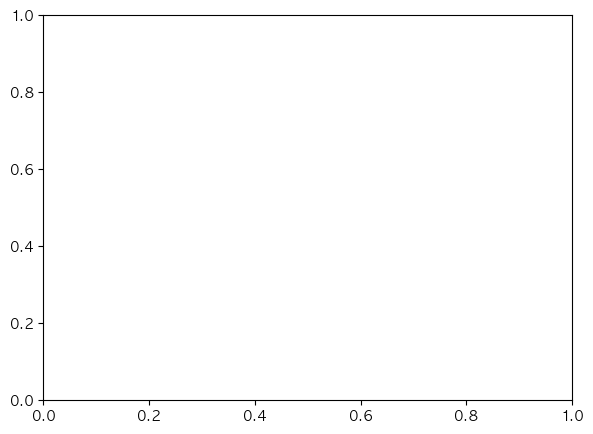

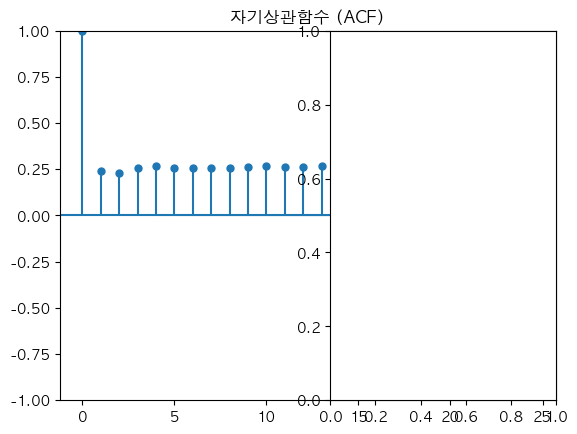

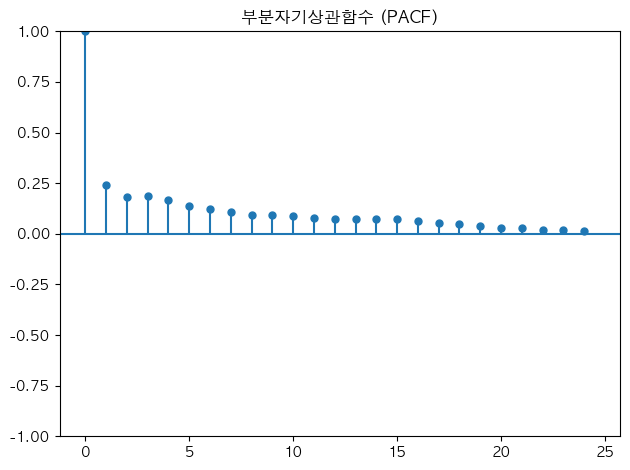

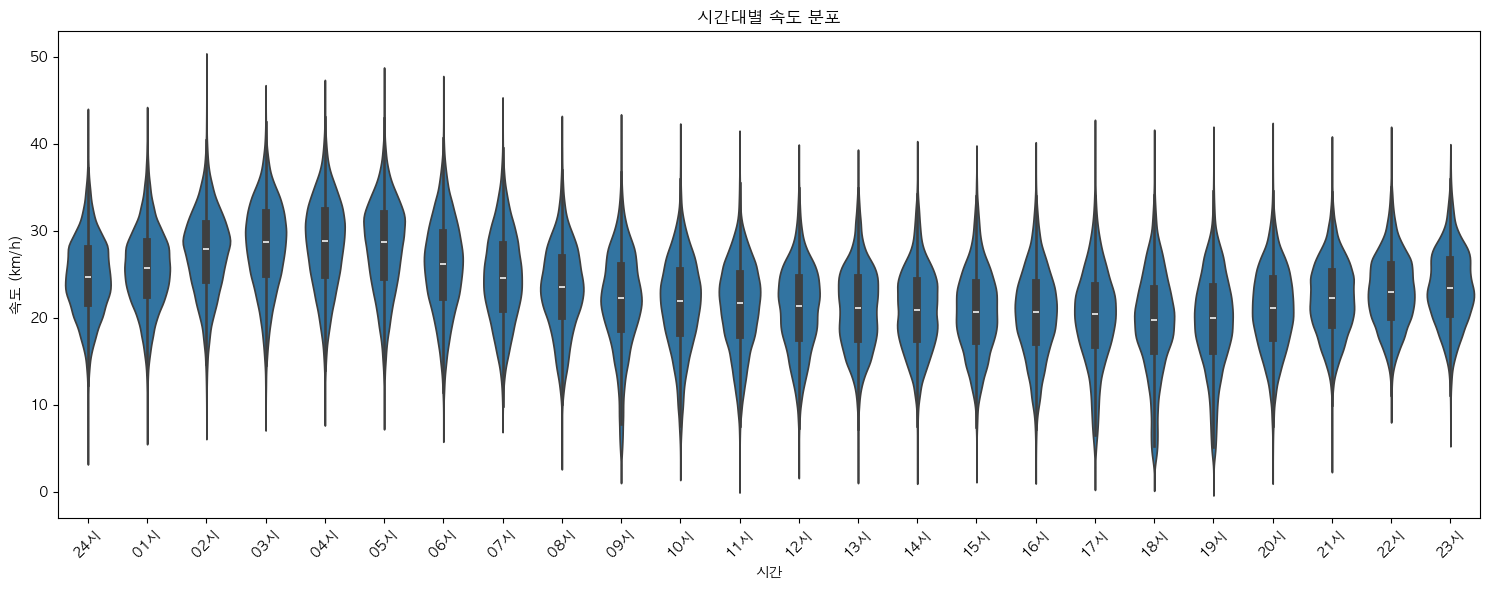

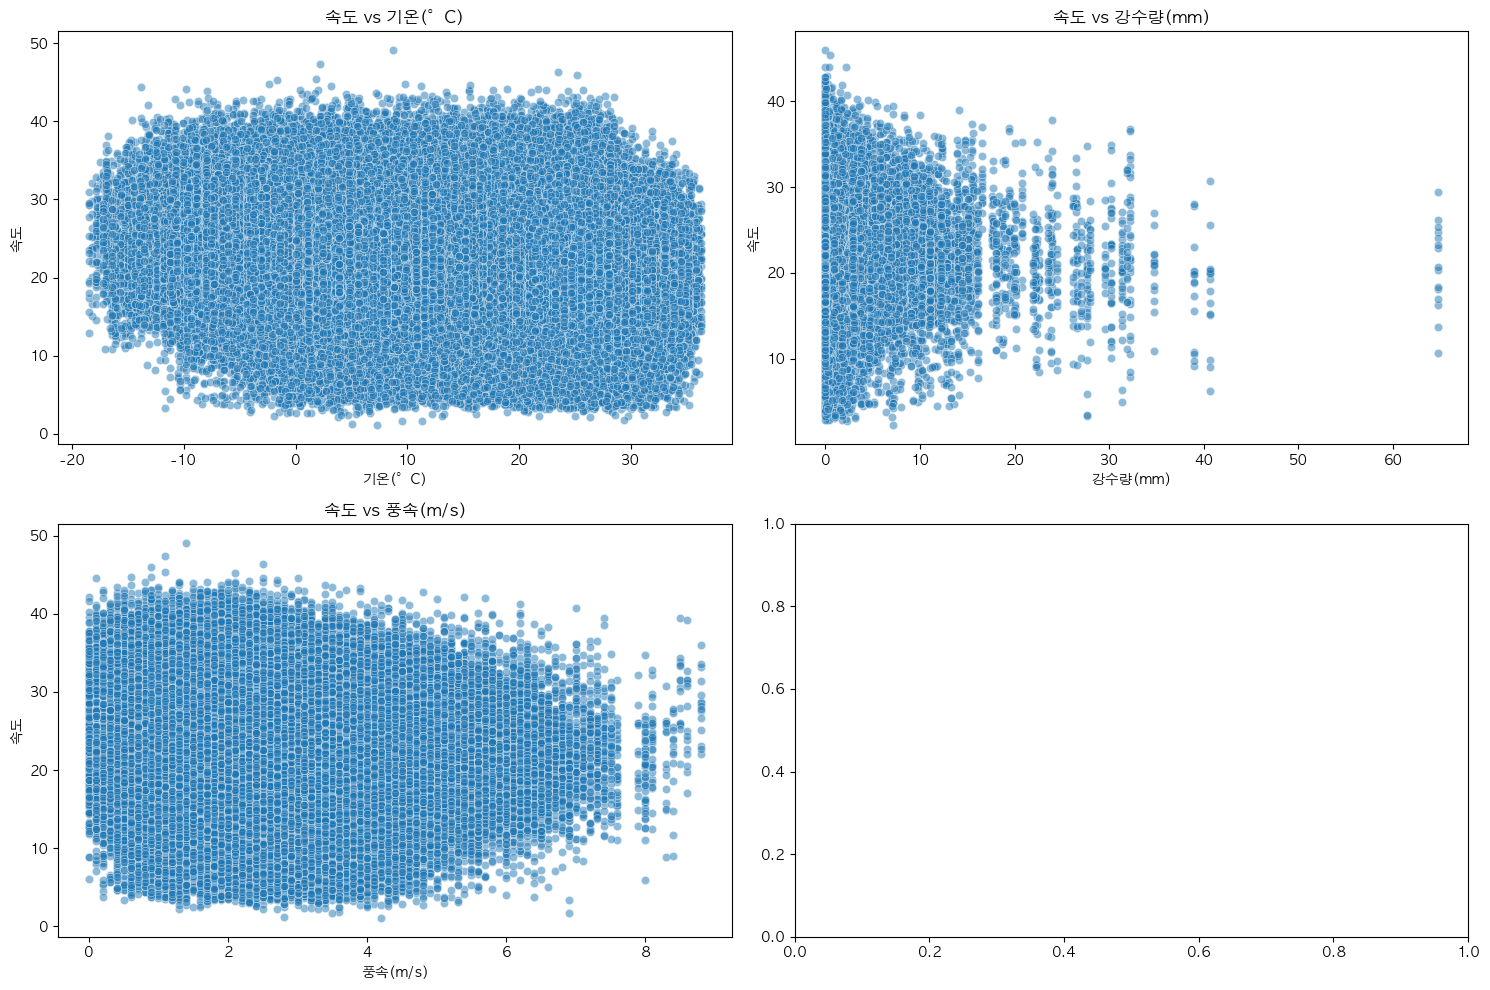

In [104]:
analyze_traffic_data(gaepo_df)


### 논현로


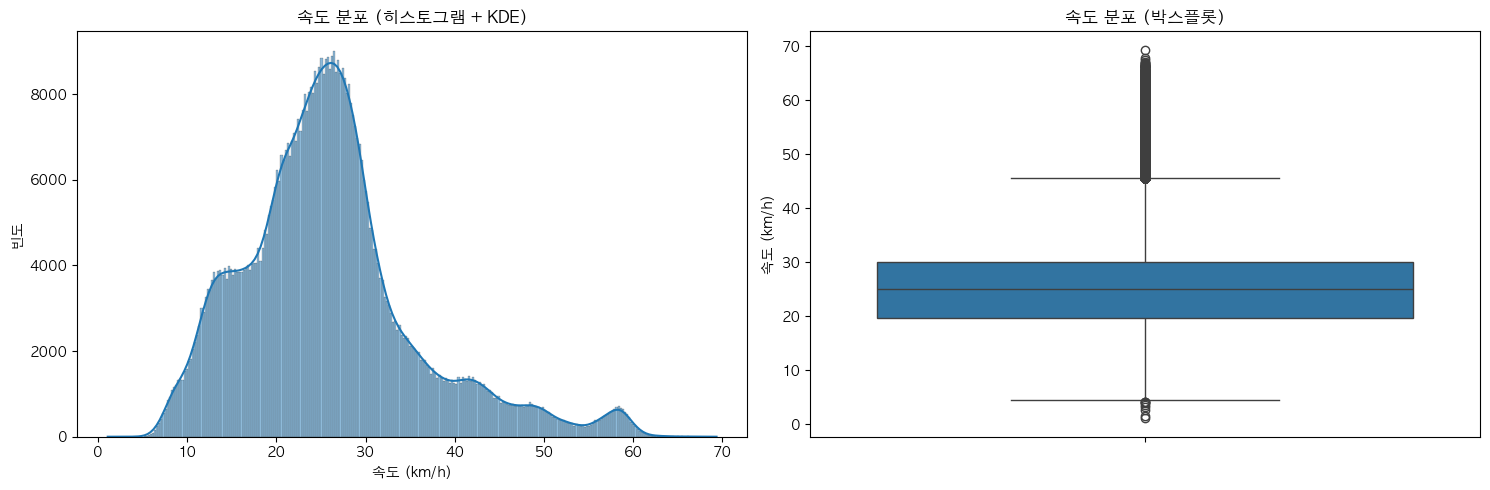

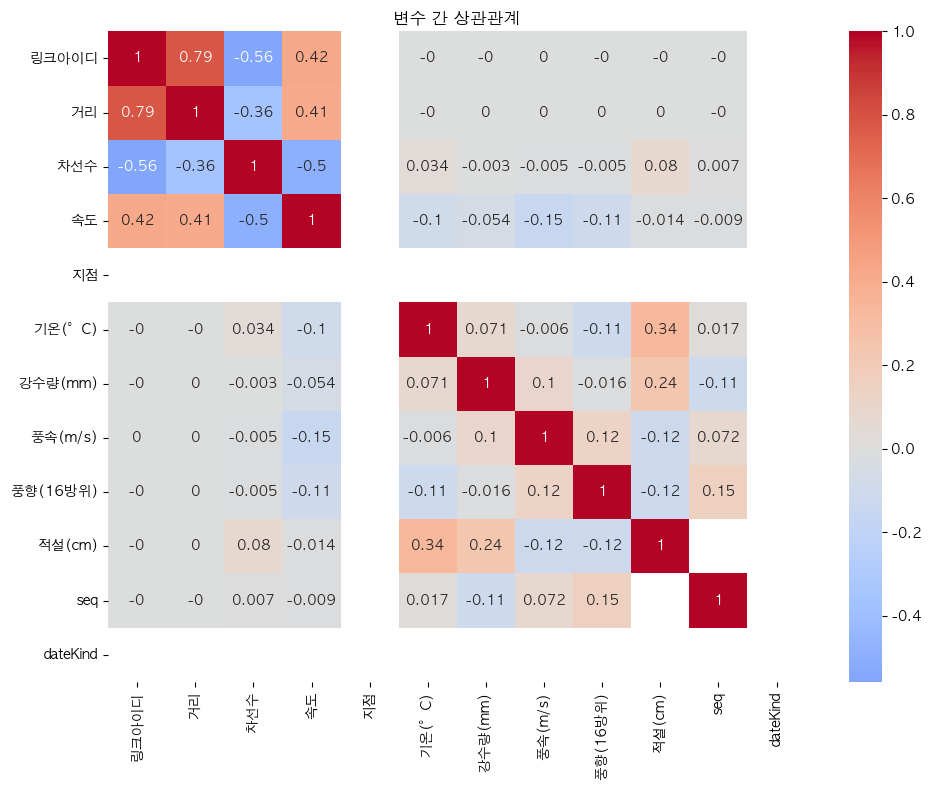


ADF 테스트 결과:
ADF 통계량: -73.42765014731464
p-value: 0.0
임계값:
	1%: -3.430
	5%: -2.862
	10%: -2.567


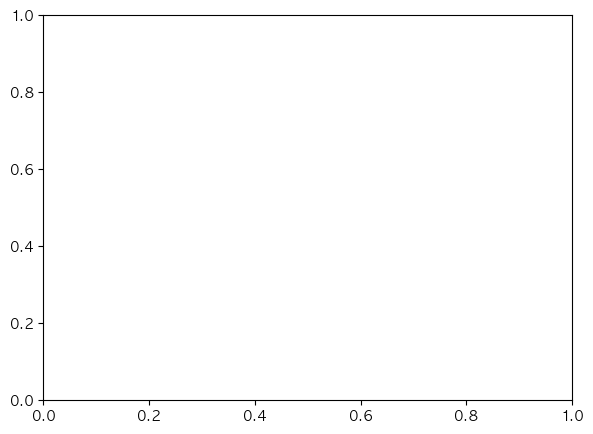

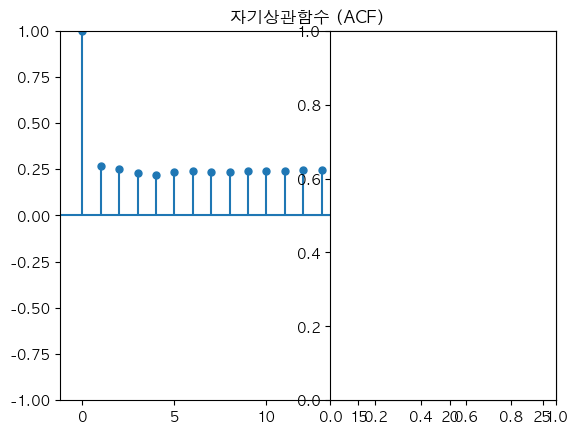

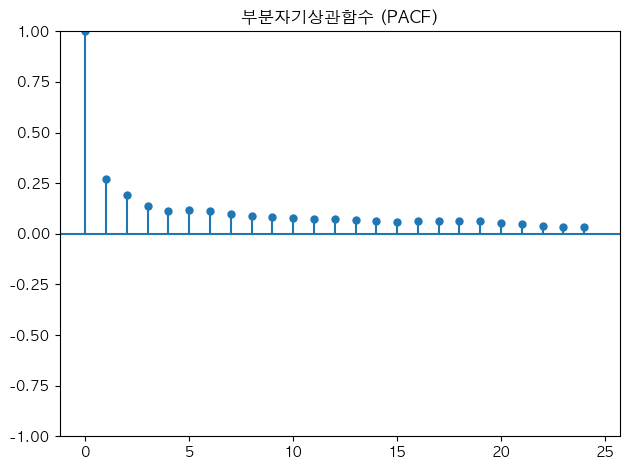

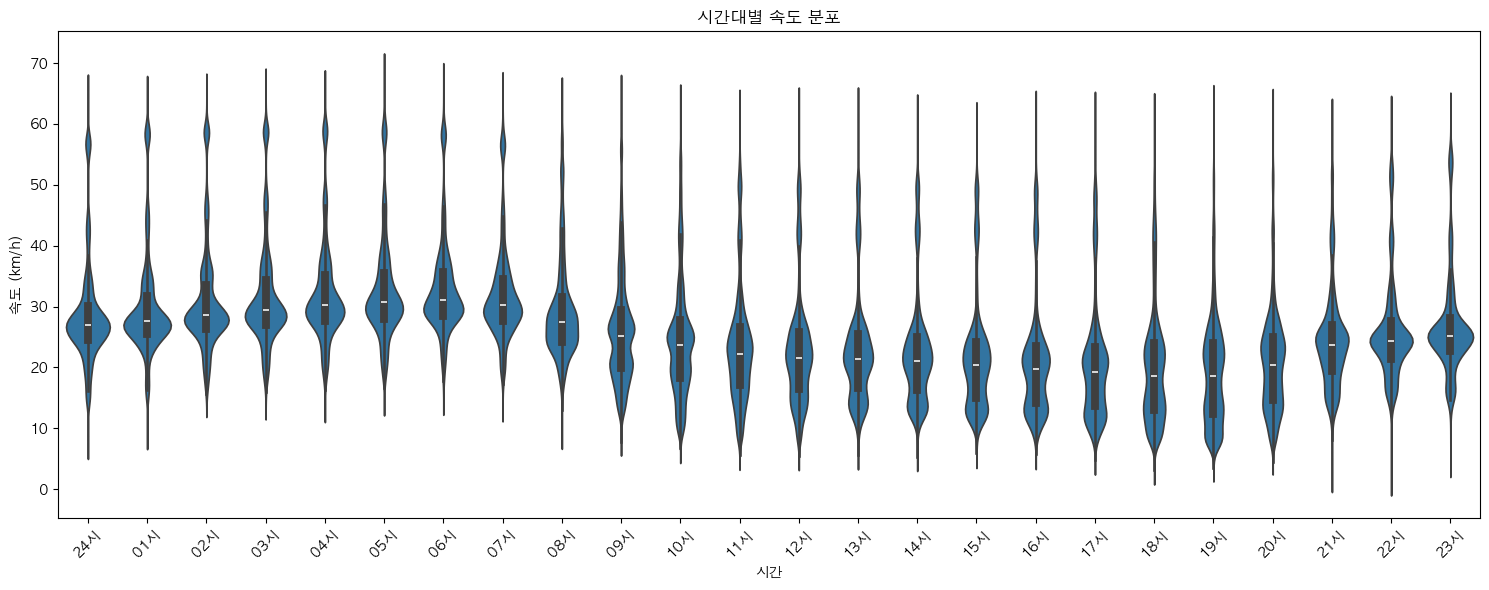

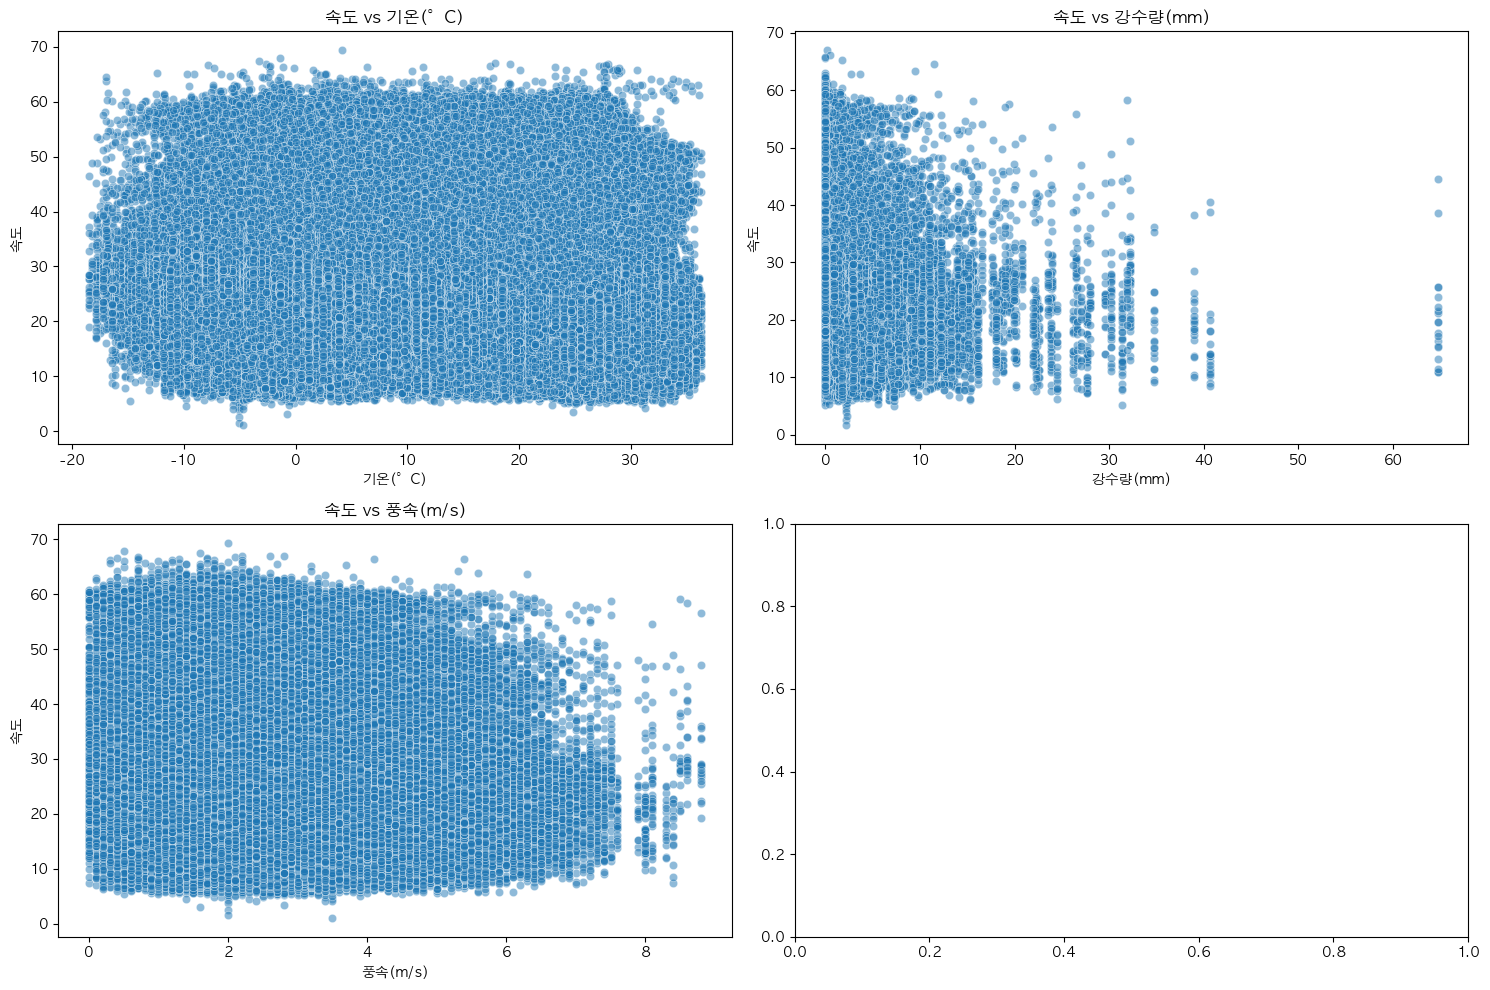

In [103]:
analyze_traffic_data(nonhyun_df)

### 전체 시간대별 평균 속도

In [55]:
# pyplot 한글 인코딩 설정
plt.rc('font', family='AppleGothic')

# 그래프에서 마이너스 기호가 깨지는 것을 방지
plt.rc('axes', unicode_minus=False)

def draw_scp(df, title=None):
    df = df.reset_index()  # 인덱스를 컬럼으로 변환
    
    # 그래프 크기와 해상도 설정
    plt.figure(figsize=(10,6), dpi=100)
    
    # 선 스타일과 마커 설정
    plt.plot(df['시간'], df['속도'], 
            marker='o',
            markersize=8,
            linewidth=2,
            linestyle='-',
            color='#2E86C1',
            markerfacecolor='white',
            markeredgecolor='#2E86C1',
            markeredgewidth=2)
    
    # 제목과 레이블 설정
    plt.title(title, fontsize=16, pad=20, fontweight='bold')
    plt.xlabel('시간', fontsize=12, labelpad=10)
    plt.ylabel('속도 (km/h)', fontsize=12, labelpad=10)
    
    # 축 설정
    plt.xticks(rotation=45, ha='right')
    plt.ylim(10, 80)
    plt.yticks(range(10, 110, 10))
    
    # 그리드 설정
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 여백 조정
    plt.tight_layout()
    
    # 그래프 테두리 추가
    plt.box(True)
    
    plt.show()

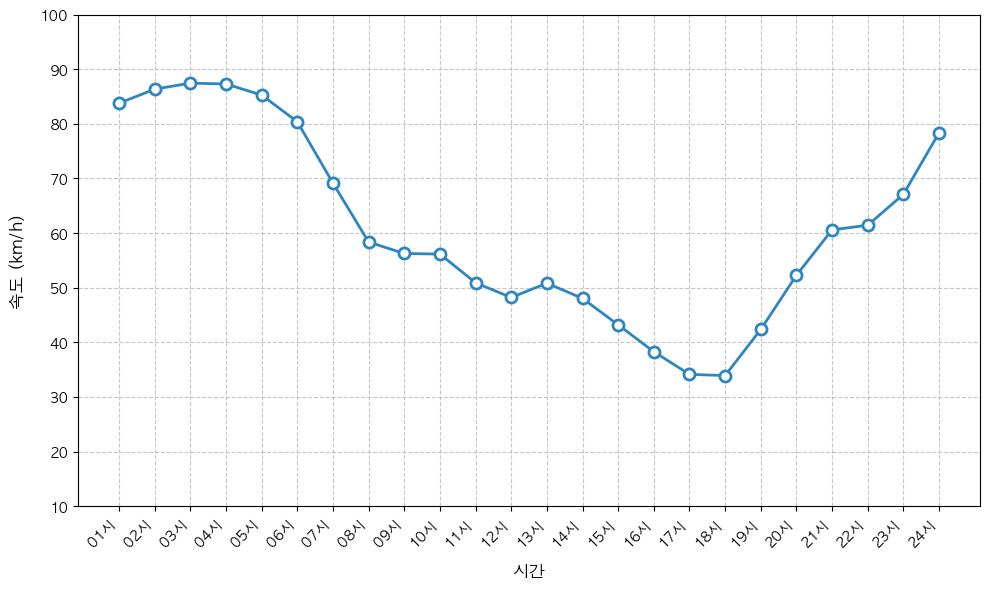

In [56]:
total_speed = olym_df.groupby('시간')['속도'].mean()
draw_scp(total_speed)

### 링크 아이디별 시간대별 평균 속도

In [88]:
link_speed = olym_df.groupby(['링크아이디', '시간'])['속도'].mean()
link_speed = link_speed.reset_index()

link_speed[link_speed['링크아이디'] == 1210006400]

링크아이디   시간         속도
0   1210006400  01시  81.026259
1   1210006400  02시  84.158208
2   1210006400  03시  85.593859
3   1210006400  04시  85.312218
4   1210006400  05시  82.174257
5   1210006400  06시  74.686268
6   1210006400  07시  64.333709
7   1210006400  08시  49.561473
8   1210006400  09시  55.617823
9   1210006400  10시  59.848037
10  1210006400  11시  52.540405
11  1210006400  12시  45.684196
12  1210006400  13시  42.937102
13  1210006400  14시  36.498457
14  1210006400  15시  32.628148
15  1210006400  16시  24.450412
16  1210006400  17시  18.560233
17  1210006400  18시  17.652551
18  1210006400  19시  29.173292
19  1210006400  20시  48.763134
20  1210006400  21시  56.218866
21  1210006400  22시  52.352663
22  1210006400  23시  59.740489
23  1210006400  24시  74.769910

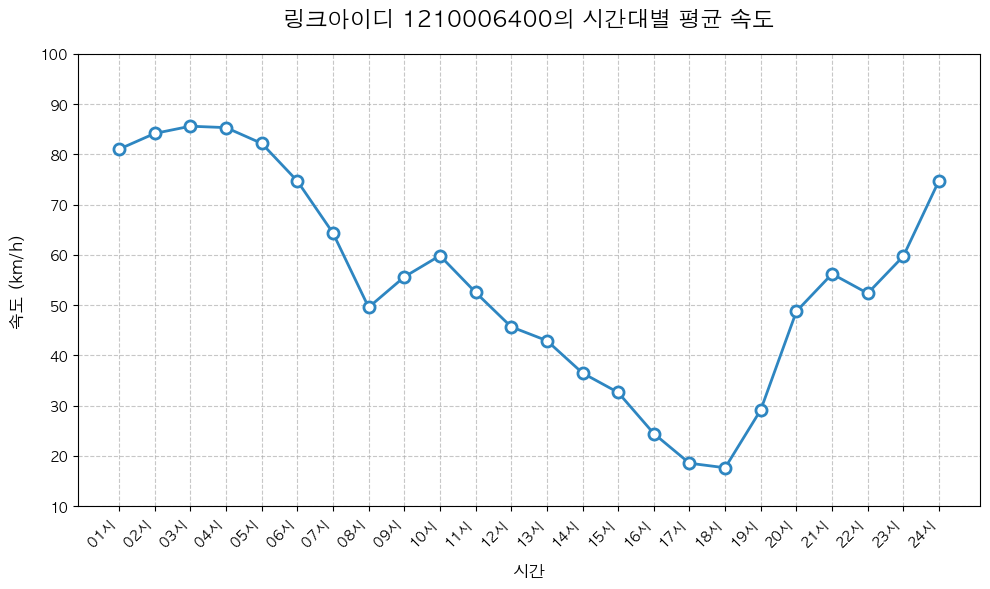

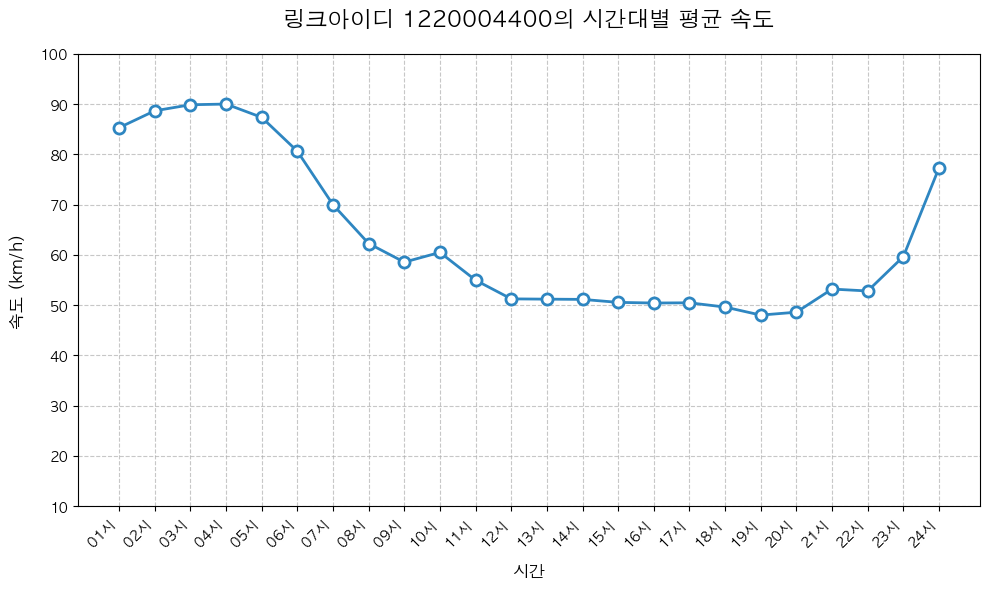

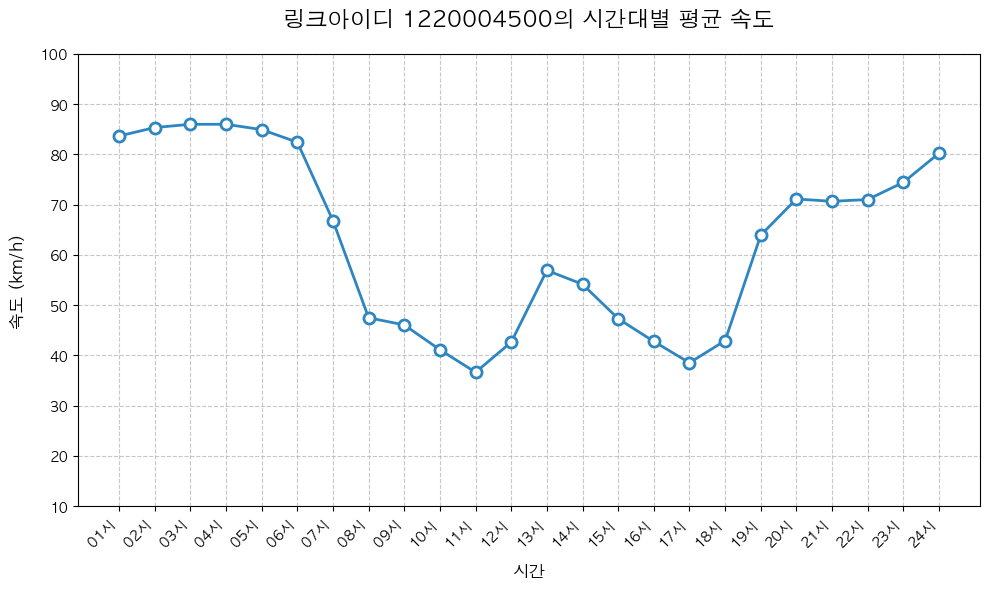

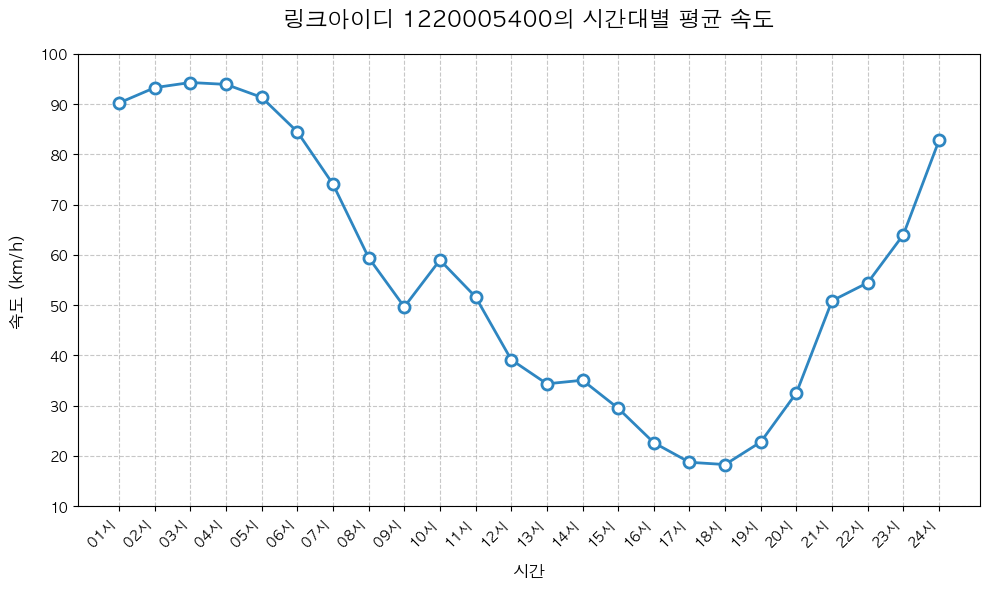

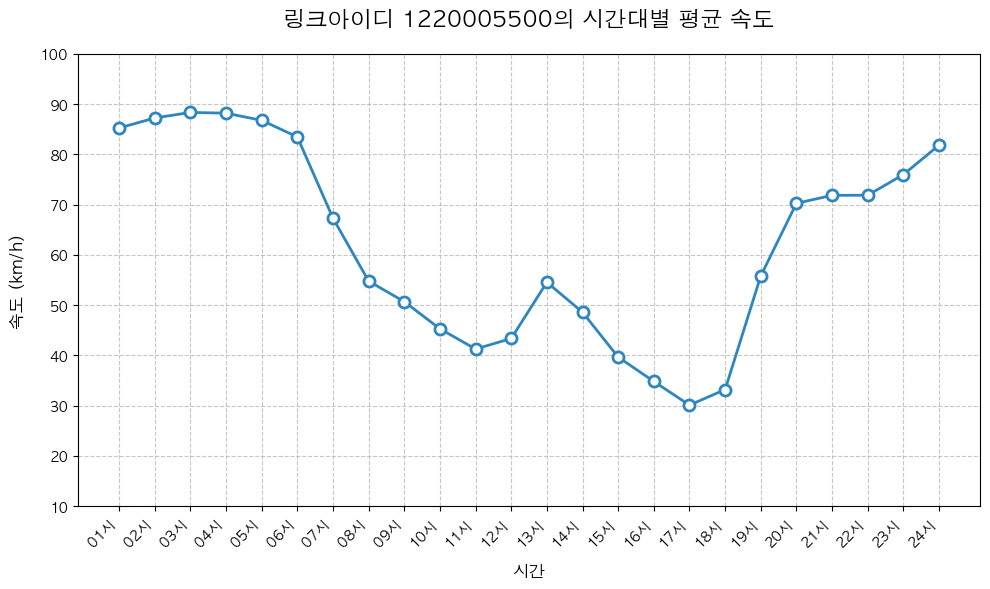

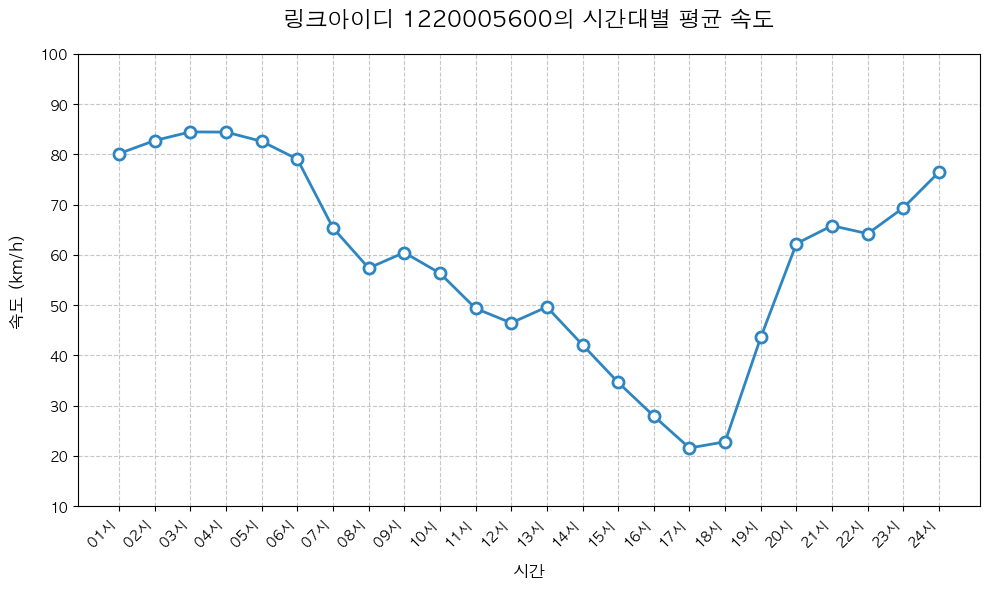

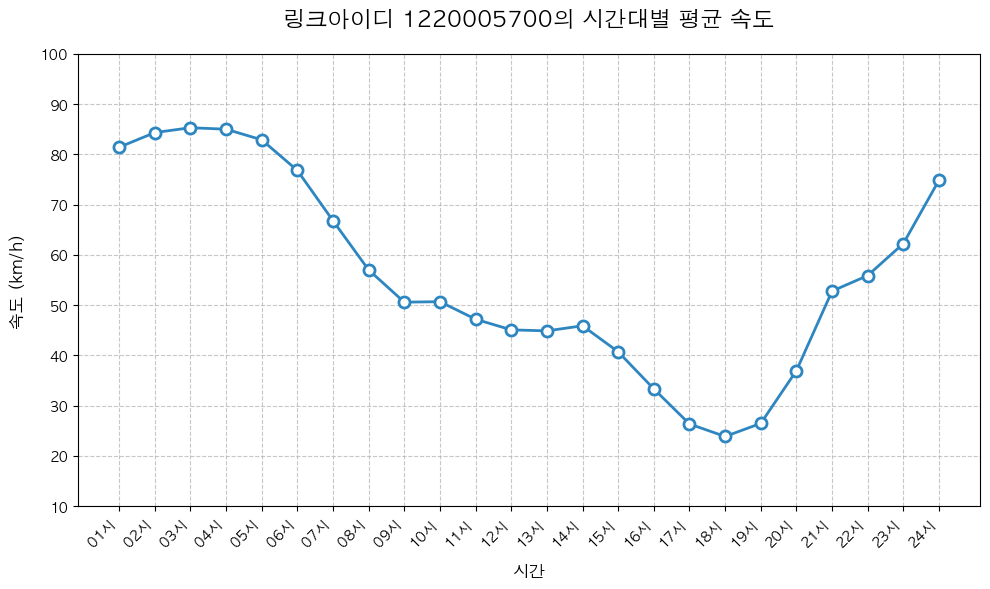

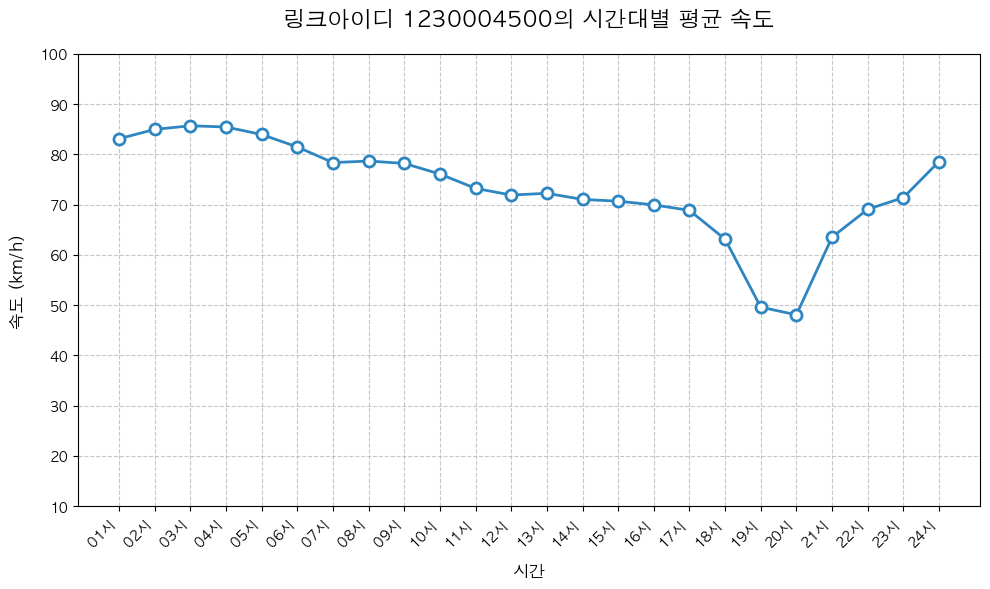

In [59]:
# 고유한 링크아이디만 가져오기
unique_links = link_speed['링크아이디'].unique()

for i in unique_links:
    link_data = link_speed[link_speed['링크아이디'] == i]
    draw_scp(link_data.set_index('시간')['속도'], title=f'링크아이디 {i}의 시간대별 평균 속도')

### 휴일/평일 시간대별 평균 속도

In [95]:
olym_df['isHoliday'].fillna(0, inplace=True)
olym_df['isHoliday'] = olym_df['isHoliday'].astype(int)
olym_df['isHoliday'].unique()

/var/folders/0t/0jprd7f95qsb1p_xmw35n4l80000gn/T/ipykernel_97355/2208992472.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  olym_df['isHoliday'].fillna(0, inplace=True)


array([1, 0])

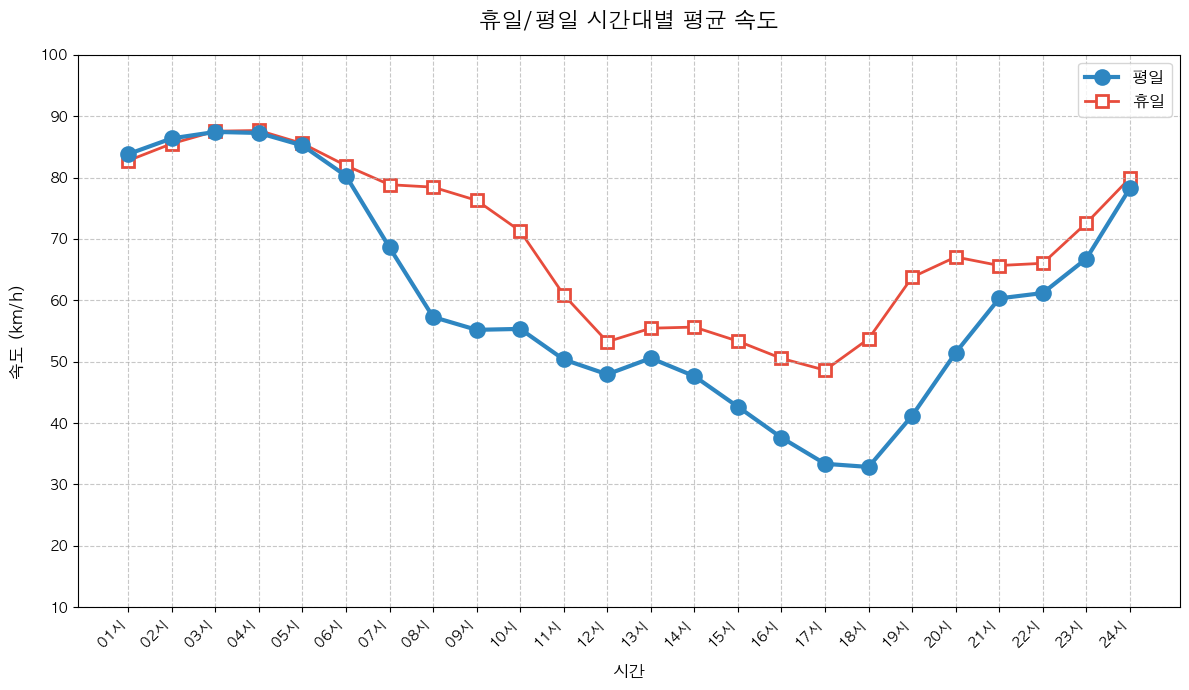

In [96]:
# 휴일/평일 데이터 분리 및 시간대별 평균 속도 계산
holiday_speed = olym_df[olym_df['isHoliday'] == 1].groupby('시간')['속도'].mean()
weekday_speed = olym_df[olym_df['isHoliday'] == 0].groupby('시간')['속도'].mean()

# 그래프 크기와 해상도 설정
plt.figure(figsize=(12,7), dpi=100)

# 평일 데이터 플롯
plt.plot(weekday_speed.index, weekday_speed.values, 
         marker='o', label='평일',
         linewidth=3, markersize=10,
         color='#2E86C1', 
         markerfacecolor='#2E86C1',
         markeredgecolor='#2E86C1',
         markeredgewidth=2,
         zorder=2)

# 휴일 데이터 플롯
plt.plot(holiday_speed.index, holiday_speed.values, 
         marker='s', label='휴일',
         linewidth=2, markersize=8,
         color='#E74C3C',
         markerfacecolor='white',
         markeredgecolor='#E74C3C',
         markeredgewidth=2,
         zorder=1)

# 그래프 스타일링
plt.title('휴일/평일 시간대별 평균 속도', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('시간', fontsize=12, labelpad=10)
plt.ylabel('속도 (km/h)', fontsize=12, labelpad=10)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.ylim(10, 80)
plt.yticks(range(10, 110, 10))

# 여백 조정
plt.tight_layout()

plt.show()

In [ ]:
# 결과를 DataFrame으로 변환
metrics_df = pd.DataFrame()

for link_id, result in results.items():
    # 각 링크의 평가 지표를 시리즈로 변환
    metrics = pd.Series(result['metrics'], name=link_id)
    metrics_df = pd.concat([metrics_df, metrics.to_frame().T])

# 인덱스 이름을 '링크아이디'로 설정
metrics_df.index.name = '링크아이디'

# 컬럼 순서 정리
column_order = [
    'Train RMSE', 'Test RMSE',
    'Train MAE', 'Test MAE',
    'Train R2', 'Test R2',
    'Train Adjusted R2', 'Test Adjusted R2'
]
metrics_df = metrics_df[column_order]

# 소수점 자리 정리
metrics_df = metrics_df.round(4)

# 결과 출력
print("링크아이디별 평가 지표 요약:")
print(metrics_df)

# CSV 파일로 저장 (선택사항)
metrics_df.to_csv('논현로_평가지표_요약.csv')